# S3: QQ Plots

In [1039]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn022


In [1040]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [1041]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)


def qq_plot(df_results, filename, figsize=(10, 16), tcga=True, title_fontsize=12):
    
    cols = 4
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Plot observed vs. theoretical p-values
        ax.scatter(expected, pvals, alpha=0.6)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[len(cohort.split("_"))-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nN genes = {df["n_genes"].unique()[0]}\nN mut = {df["n_mut"].unique()[0]}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n  -log10(p-values)")
    
    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

In [1042]:
SUBDIR = "human_mane_raw"
RUN = "run_2024-07-01_16-04-14"

datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


Gene  Uniprot_ID          Cohort     pval  qval  \
0          BRAF      P15056    TCGA_WXS_MEL  0.00001   0.0   
1          NRAS      P01111    TCGA_WXS_MEL  0.00001   0.0   
2        MAP2K1      A4QPA9    TCGA_WXS_MEL  0.00001   0.0   
3         CNOT9      D5MQE1    TCGA_WXS_MEL  0.00001   0.0   
4          RAC1      A4D2P1    TCGA_WXS_MEL  0.00001   0.0   
...         ...         ...             ...      ...   ...   
36091     UBE3C      Q15386  TCGA_WXS_CHRCC  0.04960   1.0   
36092  ATP6V0A4  A0A024R791  TCGA_WXS_CHRCC  0.05770   1.0   
36093     CREG2      Q8IUH2  TCGA_WXS_CHRCC  0.08770   1.0   
36094   GAL3ST3      Q96A11  TCGA_WXS_CHRCC  0.11200   1.0   
36095      TP53      K7PPA8  TCGA_WXS_CHRCC  0.31960   1.0   

       Score_obs_sim_top_vol  Mut_in_top_vol  Mut_in_gene  n_genes   n_mut  
0                 154.374330           245.0          269    10058  165420  
1                  57.088760           126.0          127    10058  165420  
2                   8.864405            20.0           27    10058  165420  
3                   7.687517            14.0           15    10058  165420  
4                   7.117122            18.0           22    10058  165420  
...                      ...             ...          ...      ...     ...  
36091               1.719813             2.0            2        7      28  
36092               1.685607             2.0            2        7      28  
36093               1.592002             2.0            2        7      28  
36094               1.508403             2.0            2        7      28  
36095               1.017289             4.0           16        7      28  

[36096 rows x 10 columns]

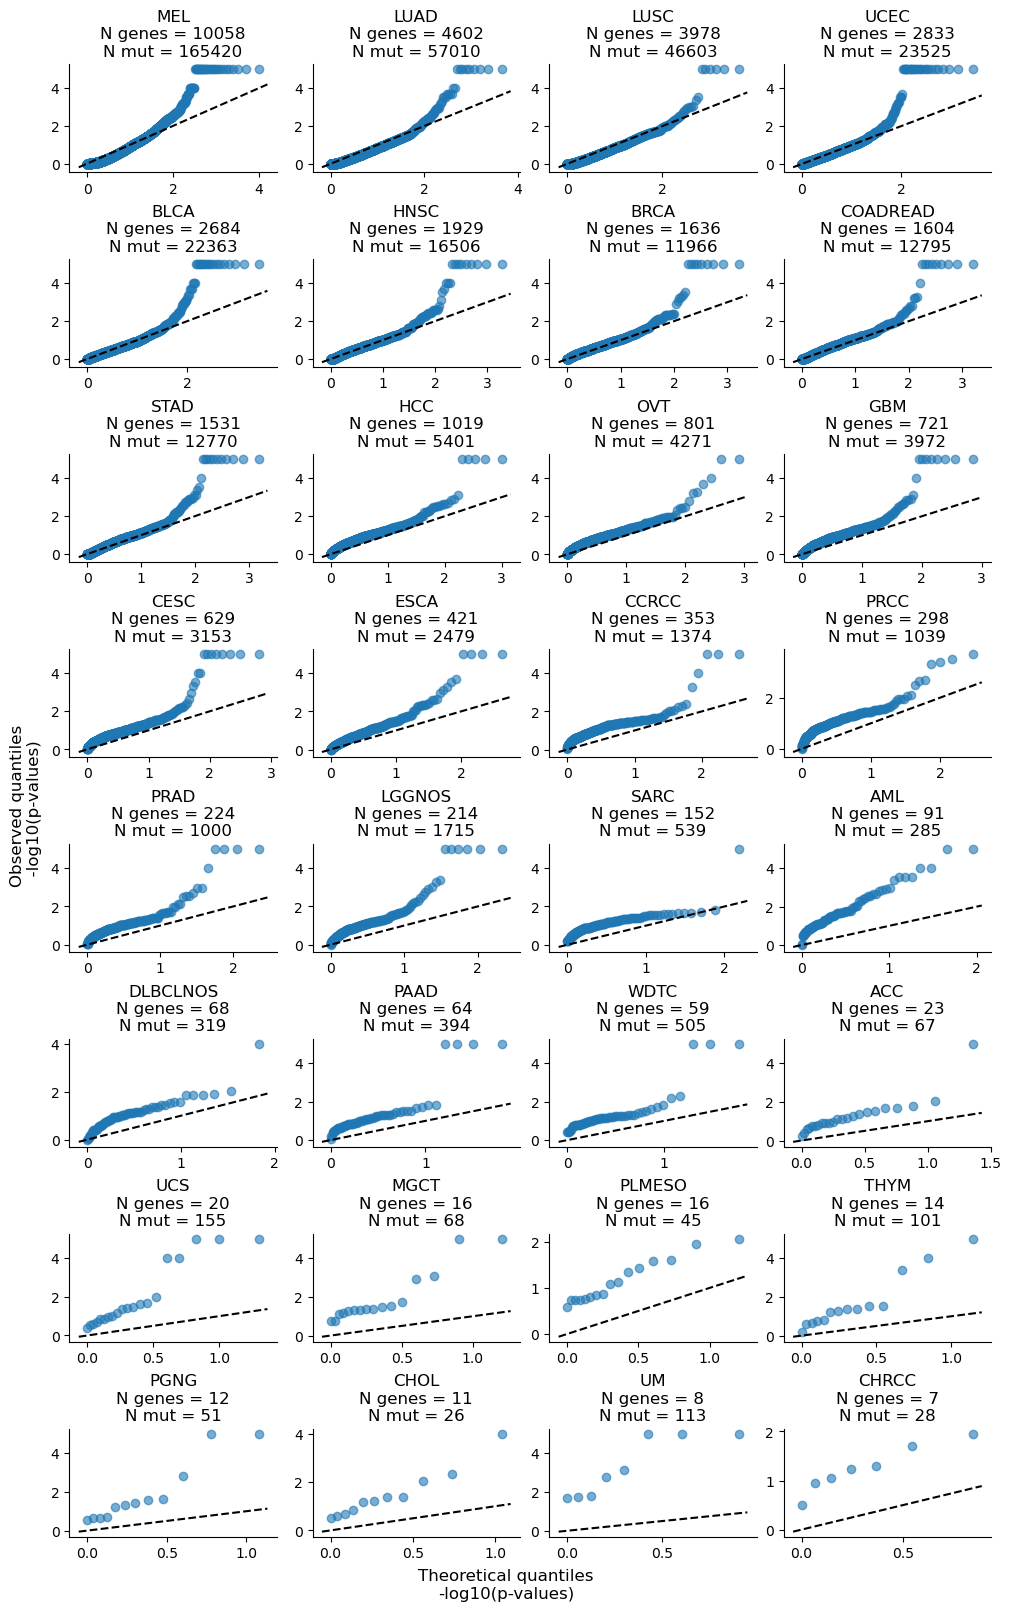

In [1043]:
qq_plot(df_results, filename=False)

## Filter by sample size (processed genes)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


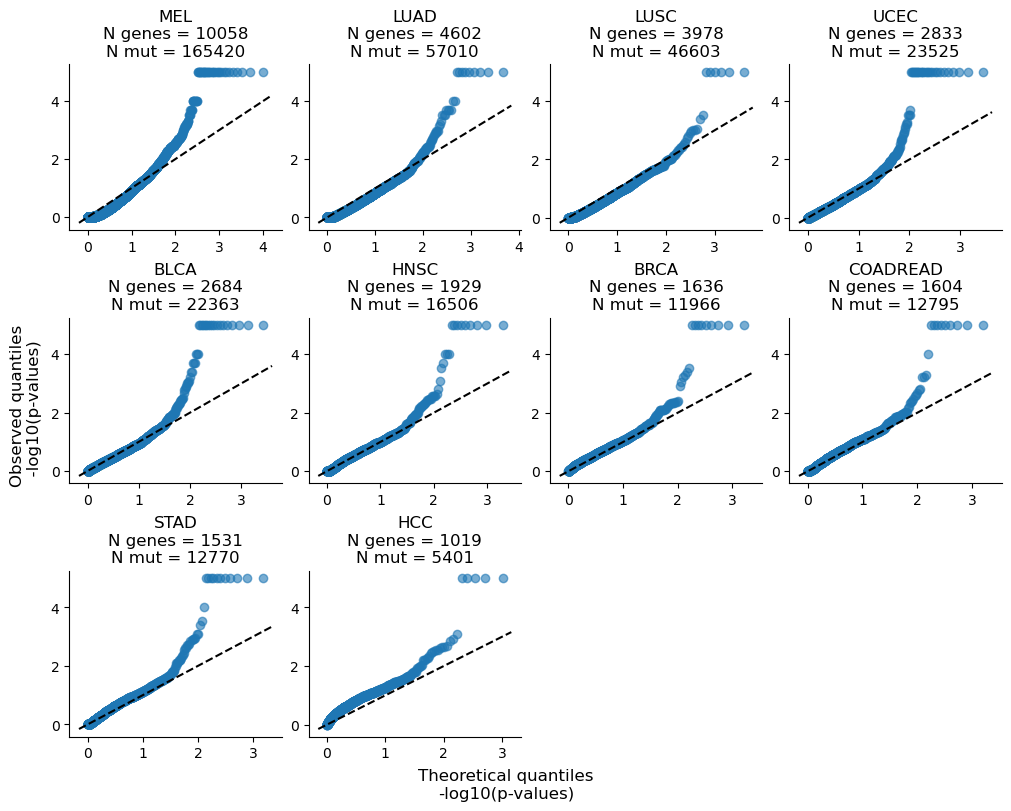

In [1044]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1000)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
qq_plot(df_results, filename=False, figsize=(10, 8))

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


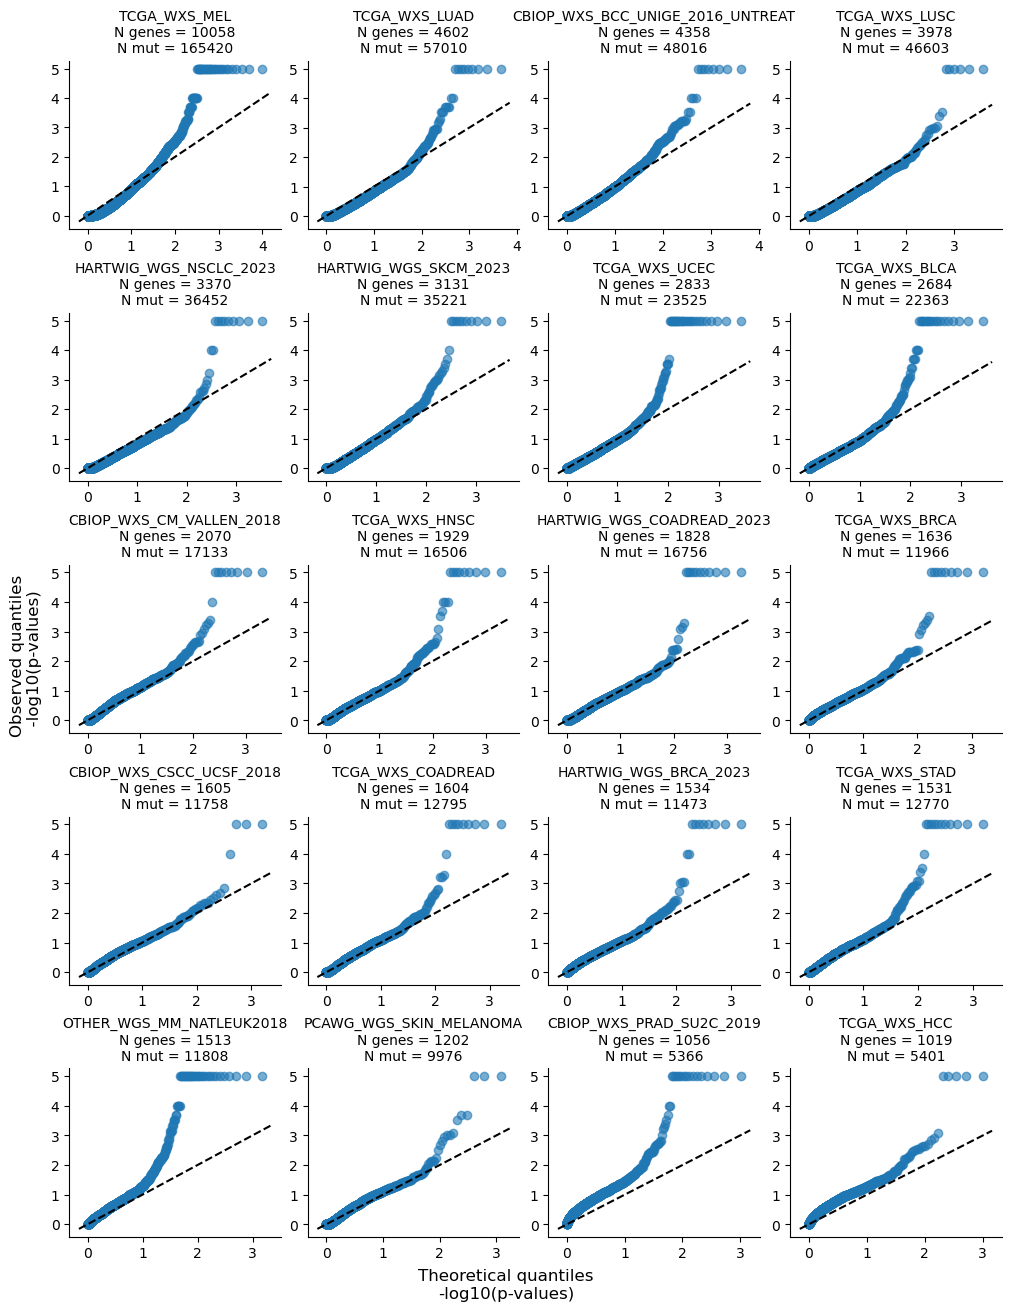

In [1045]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1000)
qq_plot(df_results, filename=False, figsize=(10, 13), tcga=False, title_fontsize=10)

## We compute the score at the level of gene-cohort: so a sample size that might affect the score is the number of number of mutations in the gene


Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


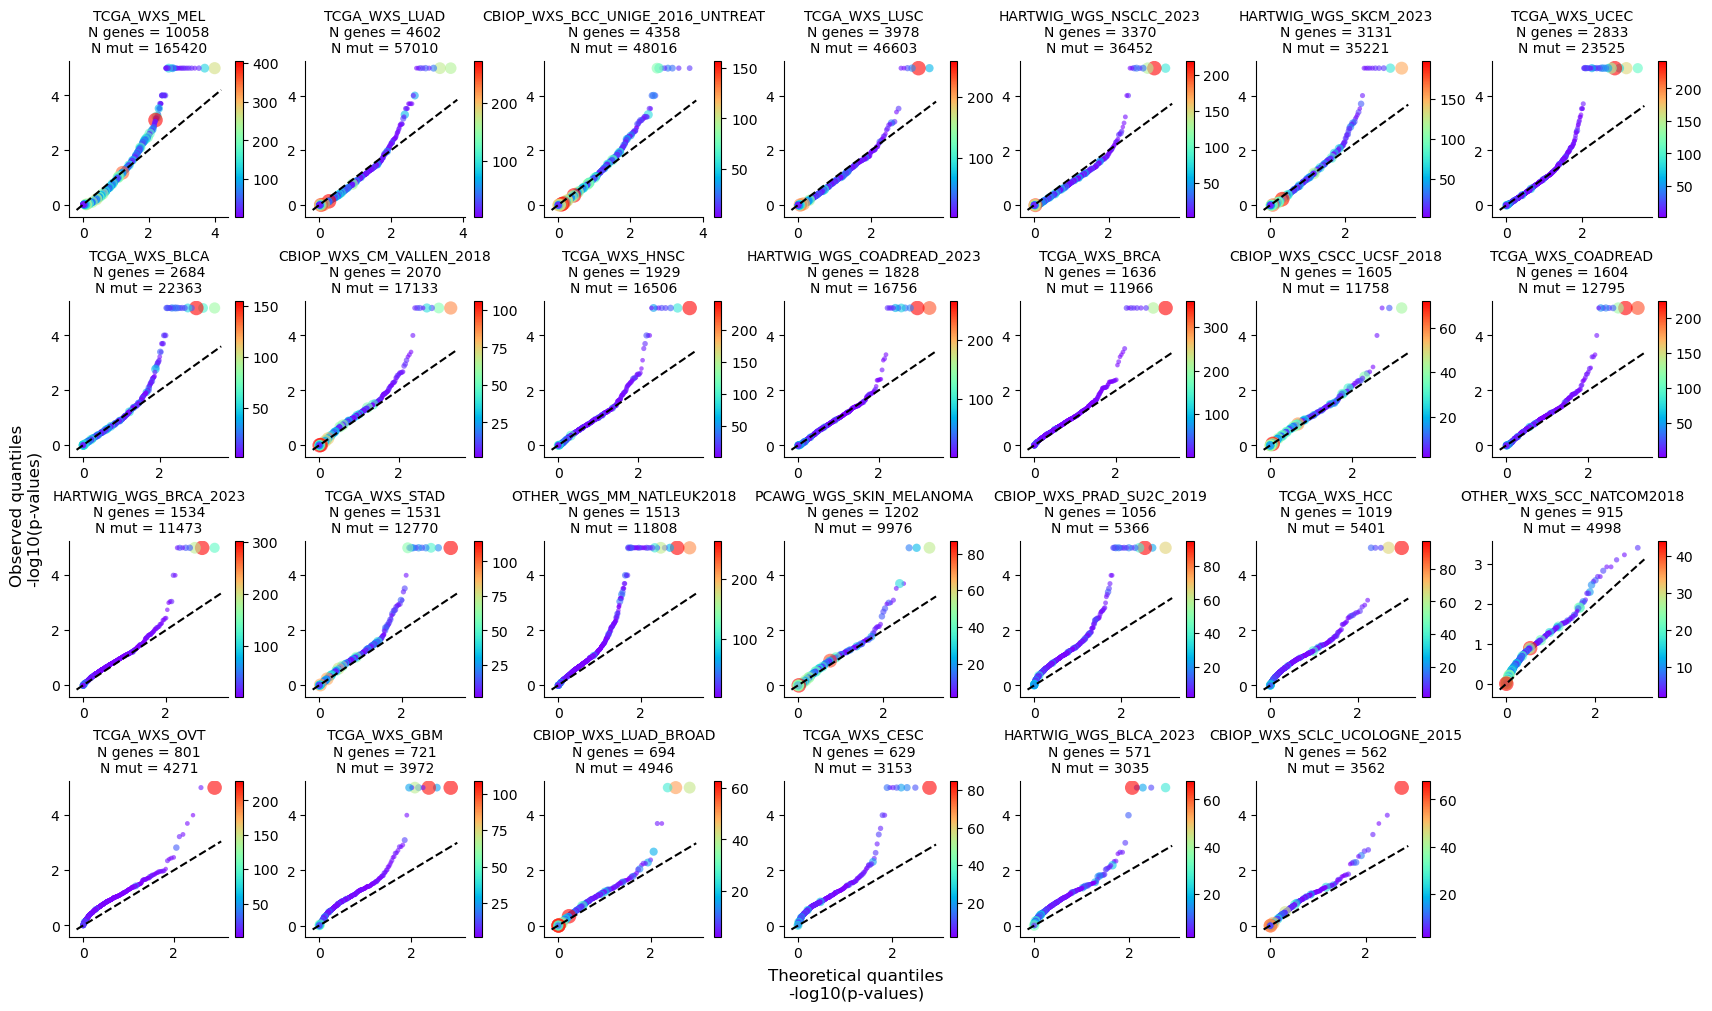

In [1046]:
def qq_plot(df_results, filename=None, figsize=(10, 16), tcga=True, title_fontsize=12, cols=4):
    
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    cmap = plt.cm.rainbow  # Using the rainbow colormap

    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Normalize colors and sizes based on Mut_in_gene
        norm = plt.Normalize(df["Mut_in_gene"].min(), df["Mut_in_gene"].max())
        size_scale = (df["Mut_in_gene"] - df["Mut_in_gene"].min()) / (df["Mut_in_gene"].max() - df["Mut_in_gene"].min())
        marker_sizes = 10 + (size_scale * 100)  # Scale marker sizes between 10 and 100

        # Scatter plot with size and color based on "Mut_in_gene"
        scatter = ax.scatter(expected, pvals, c=df["Mut_in_gene"], cmap=cmap, norm=norm, s=marker_sizes, alpha=0.6, lw=0)
        
        # Expected line (y=x)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nN genes = {df["n_genes"].unique()[0]}\nN mut = {df["n_mut"].unique()[0]}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add color bar next to each subplot
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', 
                            fraction=1, pad=0.04)
        # cbar.set_label("Mutations in Gene")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Common x and y labels
    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n-log10(p-values)")

    # Save the figure if filename is provided
    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=500)
qq_plot(df_results, filename=False, figsize=(17, 10), tcga=False, title_fontsize=10, cols=7)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


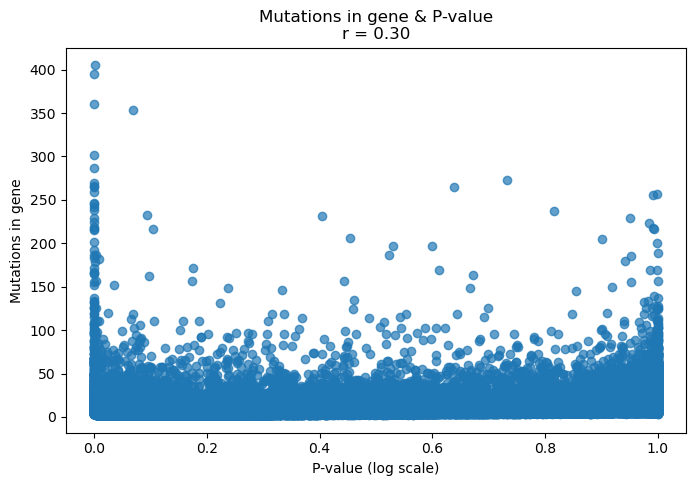

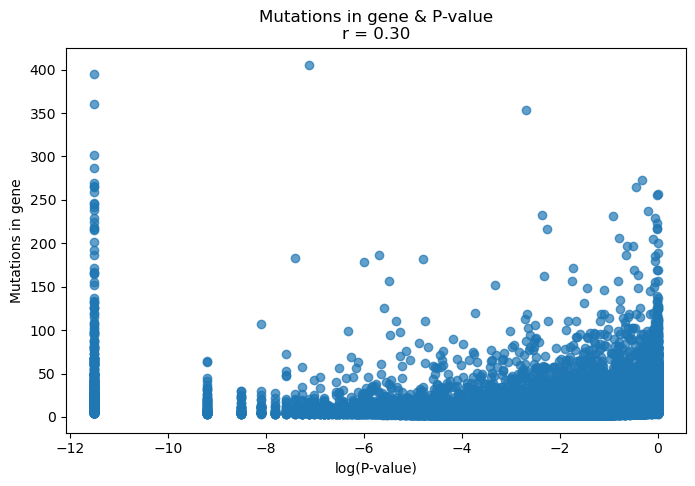

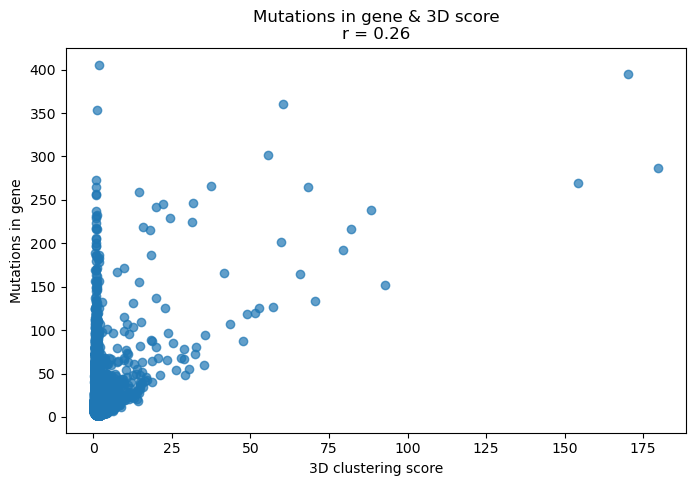

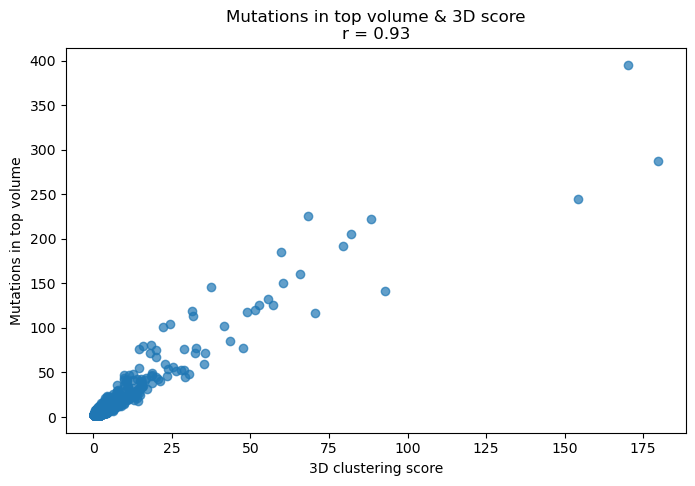

In [1047]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["pval"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("P-value (log scale)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(np.log(df["pval"]), df["Mut_in_gene"], alpha=0.7)
plt.xlabel("log(P-value)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_top_vol"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in top volume")
plt.title(f'Mutations in top volume & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_top_vol"]):.2f}')
plt.show()



In [1048]:
# Detected genes and score distribution
df_results_norm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False)
df_results_norm = df_results_norm[df_results_norm["qval"] < 0.01]
print("Detected gene-cancer:", len(df_results_norm))
print("Detected gene:", len(df_results_norm.Gene.unique()))

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Detected gene-cancer: 619
Detected gene: 273


# Not-normalized 3D clustering score

## Oncodrive3D result

In [1049]:
SUBDIR = "review"
RUN = "run_notnorm_2025-03-26_10-58-45"

In [1050]:
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


Gene  Uniprot_ID          Cohort     pval  qval  \
0          BRAF      P15056    TCGA_WXS_MEL  0.00001   0.0   
1          NRAS      P01111    TCGA_WXS_MEL  0.00001   0.0   
2        MAP2K1      A4QPA9    TCGA_WXS_MEL  0.00001   0.0   
3          RAC1      A4D2P1    TCGA_WXS_MEL  0.00001   0.0   
4         CNOT9      D5MQE1    TCGA_WXS_MEL  0.00001   0.0   
...         ...         ...             ...      ...   ...   
36089    SCAPER      Q9BY12  TCGA_WXS_CHRCC  0.01930   1.0   
36090     UBE3C      Q15386  TCGA_WXS_CHRCC  0.04940   1.0   
36091  ATP6V0A4  A0A024R791  TCGA_WXS_CHRCC  0.05770   1.0   
36092     CREG2      Q8IUH2  TCGA_WXS_CHRCC  0.08770   1.0   
36093      TP53      K7PPA8  TCGA_WXS_CHRCC  0.71050   1.0   

       Score_obs_sim_top_vol  Mut_in_top_vol  Mut_in_gene  n_genes   n_mut  
0                 161.396484           243.0          269    10058  165420  
1                  66.875076           122.0          127    10058  165420  
2                   8.509448            20.0           27    10058  165420  
3                   8.464008            18.0           22    10058  165420  
4                   7.297280            14.0           15    10058  165420  
...                      ...             ...          ...      ...     ...  
36089               1.491021             2.0            2        7      28  
36090               1.517692             2.0            2        7      28  
36091               1.371249             2.0            2        7      28  
36092               1.188918             2.0            2        7      28  
36093               0.867858             3.0           16        7      28  

[36094 rows x 10 columns]

In [1051]:
path = f"{datasets}/output/cancer_202404/o3d_output/review/{RUN}/TCGA_WXS_BLCA/TCGA_WXS_BLCA.3d_clustering_pos.csv"
df = pd.read_csv(path)
df

Gene Uniprot_ID   Pos  Mut_in_gene  Mut_in_res  Mut_in_vol     Score  \
0      AADAT     Q4W5N8    66            4           1           2  4.105037   
1      AADAT     Q4W5N8    68            4           1           2  3.809423   
2      AADAT     Q4W5N8   105            4           1           1  2.628673   
3      AADAT     Q4W5N8   313            4           1           1  2.005367   
4       AAR2     Q9Y312   237            3           1           2  6.073210   
...      ...        ...   ...          ...         ...         ...       ...   
21153  ZZEF1     O43149   736           17           1           1  2.199094   
21154  ZZEF1     O43149    77           17           1           1  1.998549   
21155  ZZEF1     O43149  1347           17           1           1  1.921324   
21156  ZZEF1     O43149   935           17           1           1  1.938244   
21157  ZZEF1     O43149   275           17           1           1  1.473284   

       Score_obs_sim    pval  C  ...  Clump  Rank  Mut_in_cl_vol  Res_in_cl  \
0           0.725810  0.8473  0  ...    NaN     0            NaN        NaN   
1           0.742222  0.8784  0  ...    NaN     1            NaN        NaN   
2           0.549844  1.0000  0  ...    NaN     2            NaN        NaN   
3           0.444036  1.0000  0  ...    NaN     3            NaN        NaN   
4           1.154828  0.3088  0  ...    NaN     0            NaN        NaN   
...              ...     ... ..  ...    ...   ...            ...        ...   
21153       0.409601  1.0000  0  ...    NaN     9            NaN        NaN   
21154       0.404507  1.0000  0  ...    NaN    13            NaN        NaN   
21155       0.403404  1.0000  0  ...    NaN    15            NaN        NaN   
21156       0.399616  1.0000  0  ...    NaN    14            NaN        NaN   
21157       0.314848  1.0000  0  ...    NaN    16            NaN        NaN   

       PAE_vol  pLDDT_res  pLDDT_vol  pLDDT_cl_vol  Cancer         Cohort  
0          0.5      97.56      98.03           NaN     NaN  TCGA_WXS_BLCA  
1          0.5      98.50      98.03           NaN     NaN  TCGA_WXS_BLCA  
2          0.0      97.38      97.38           NaN     NaN  TCGA_WXS_BLCA  
3          0.0      98.12      98.12           NaN     NaN  TCGA_WXS_BLCA  
4          0.5      96.77      96.34           NaN     NaN  TCGA_WXS_BLCA  
...        ...        ...        ...           ...     ...            ...  
21153      NaN      94.53      94.53           NaN     NaN  TCGA_WXS_BLCA  
21154      NaN      76.78      76.78           NaN     NaN  TCGA_WXS_BLCA  
21155      NaN      68.42      68.42           NaN     NaN  TCGA_WXS_BLCA  
21156      NaN      90.86      90.86           NaN     NaN  TCGA_WXS_BLCA  
21157      NaN      83.87      83.87           NaN     NaN  TCGA_WXS_BLCA  

[21158 rows x 21 columns]

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


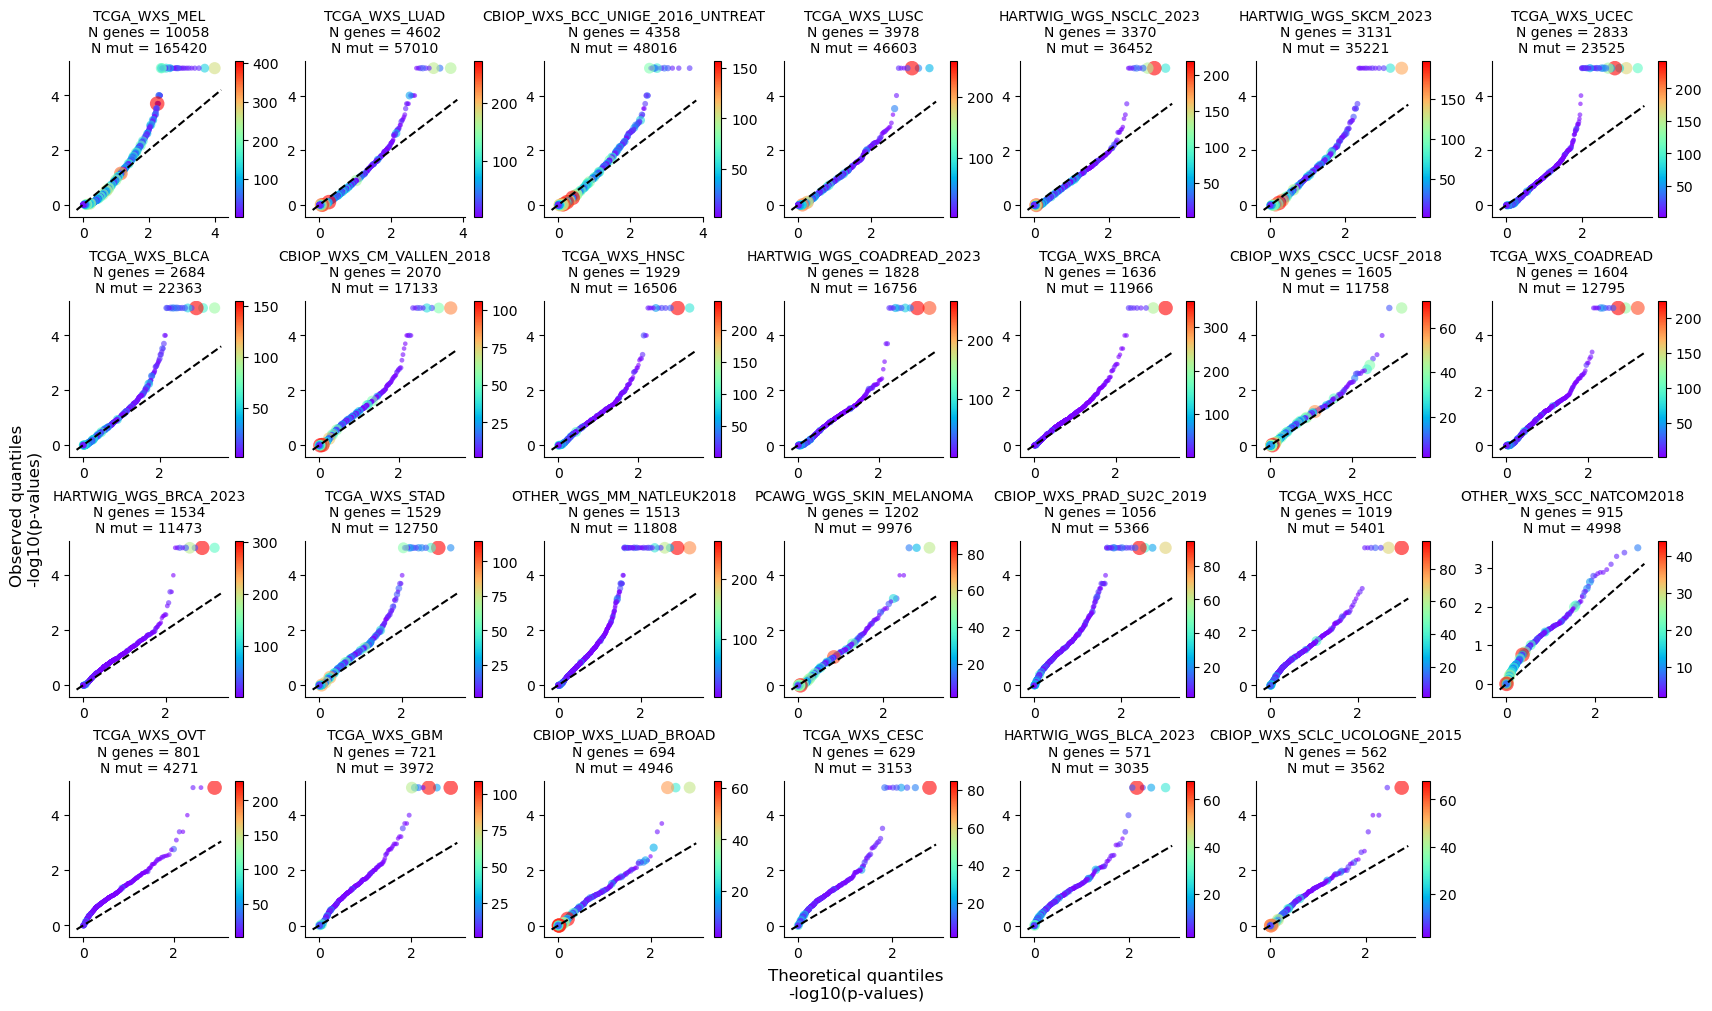

In [1052]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=500)
qq_plot(df_results, filename=False, figsize=(17, 10), tcga=False, title_fontsize=10, cols=7)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


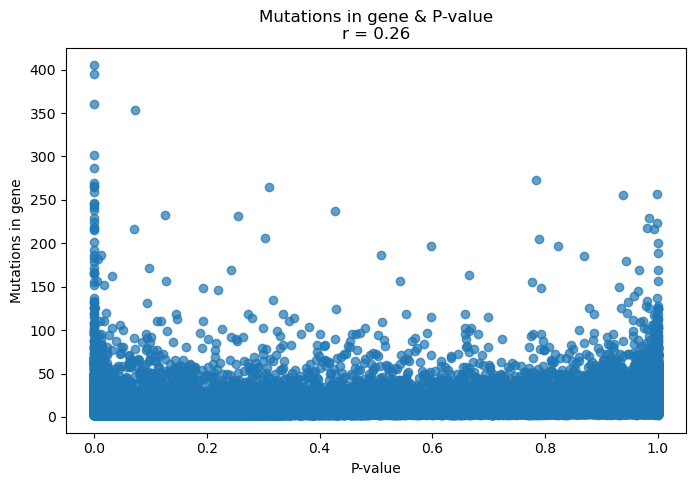

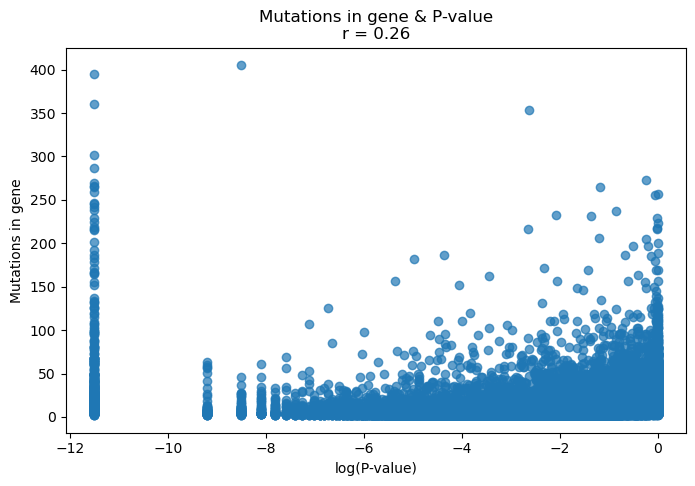

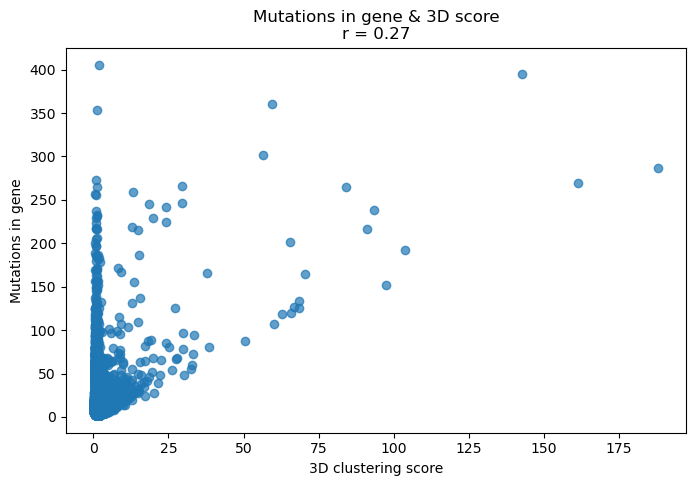

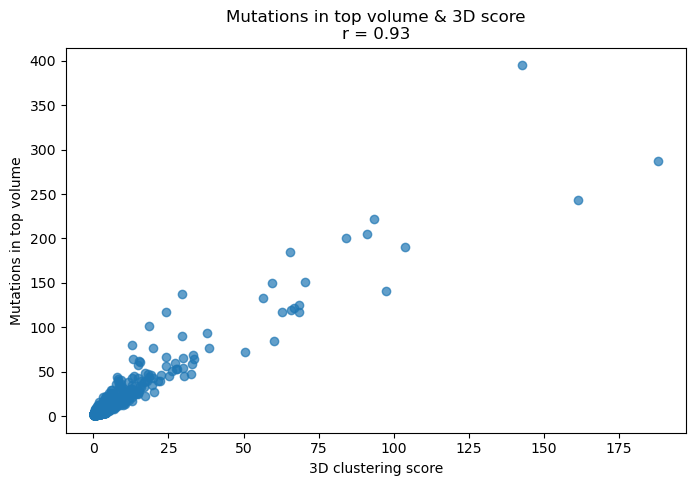

In [1053]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["pval"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("P-value")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(np.log(df["pval"]), df["Mut_in_gene"], alpha=0.7)
plt.xlabel("log(P-value)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_top_vol"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in top volume")
plt.title(f'Mutations in top volume & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_top_vol"]):.2f}')
plt.show()

In [1054]:
# Detected genes and score distribution
df_results_notnorm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False)
df_results_notnorm = df_results_notnorm[df_results_notnorm["qval"] < 0.01]
print("Detected gene-cancer:", len(df_results_notnorm))
print("Detected gene:", len(df_results_notnorm.Gene.unique()))

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Detected gene-cancer: 740
Detected gene: 363


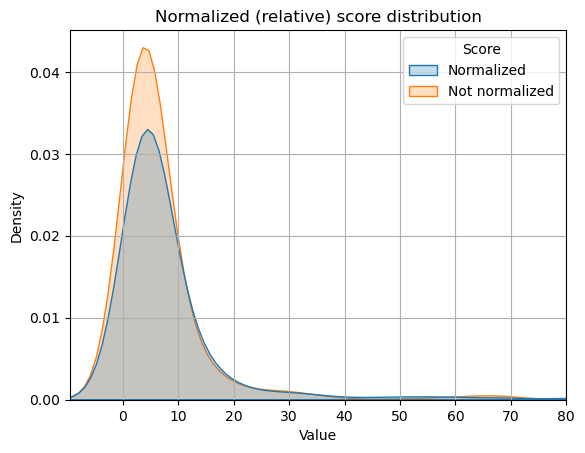

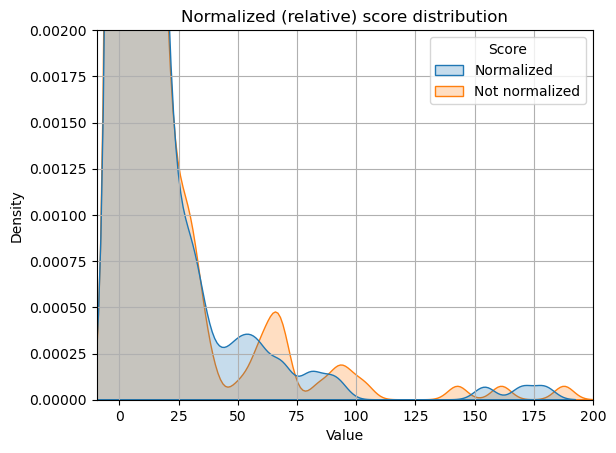

In [ ]:
# Score distribution

df_results_norm["Score"] = "Normalized"
df_results_notnorm["Score"] = "Not normalized"
df_results_plot = pd.concat((df_results_norm[["Score", "Score_obs_sim_top_vol"]], df_results_notnorm[["Score", "Score_obs_sim_top_vol"]]))

sns.kdeplot(data = df_results_plot, x="Score_obs_sim_top_vol", fill=True, hue="Score")
plt.title("Normalized (relative) score distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(-9.5, 80)
plt.grid(True)
plt.show()

sns.kdeplot(data = df_results_plot, x="Score_obs_sim_top_vol", fill=True, hue="Score")
plt.title("Normalized (relative) score distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(-9.5, 200)
plt.ylim(0, 0.002)
plt.grid(True)
plt.show()

## Analysis of the 3D clustering score

In [1055]:
from functools import reduce
import operator
from decimal import Decimal, getcontext
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def dcm_factorial(n):
    """
    Compute factorial.
    """
    return reduce(operator.mul, [Decimal(i) for i in range(1, int(n)+1)], Decimal(1))


def dcm_binom_coeff(n, k):
    """
    Compute binomial coefficient.
    """
    
    return dcm_factorial(n) / (dcm_factorial(k) * dcm_factorial(n - k))


def dcm_binom_cdf(k, n, p):
    """
    Compute binomial cumulative distribution function (CDF).
    """
    
    p = Decimal(p)
    q = Decimal(1) - p
    cdf = Decimal(0)
    for i in range(int(k) + 1):
        cdf += dcm_binom_coeff(n, i) * (p ** i) * (q ** (n - i))
        
    return cdf


def dcm_binom_sf(k, n, p):
    """
    Compute binomial survival function (SF).
    """
    
    return Decimal('1') - dcm_binom_cdf(k, n, p)


def dcm_binom_logsf(k, n, p):
    """
    Compute log binomial survival function.
    """
    
    sf = dcm_binom_sf(k, n, p)
    if sf <= 0:
        return np.inf
    return sf.ln()


def get_dcm_anomaly_score(k, n, p, decimal=600):          
    """
    Use the decimal package to compute the anomaly score 
    with high precision to avoid approximation of the 
    numerator.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    getcontext().prec = decimal
    num = dcm_binom_logsf(k-1, n, p)
    den = stats.binom.logpmf(k=n, n=n, p=p)

    return float(num / Decimal(den))


def get_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    
    den = stats.binom.logpmf(k=gene_mut, n=gene_mut, p=vec_vol_miss_mut_prob)
    score = stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob) / den

    return score if not np.isinf(score) else get_dcm_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob)



def get_dcm_anomaly_score_notnorm(k, n, p, decimal=600):          
    """
    Use the decimal package to compute the anomaly score 
    with high precision to avoid approximation of the 
    numerator.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    return dcm_binom_logsf(k-1, n, p)


def get_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    

    score = -stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob)

    return score if not np.isinf(score) else -get_dcm_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [1062]:
def plot_score_comparison(n_points=30, n_fixed=30, p_fixed=1e-8, figsize=(12, 10), annot=False):

    # 1. Vary x and y, fix p
    k_vals = np.arange(1, n_points+1)
    n_vals = np.arange(1, n_points+1)
    K, N = np.meshgrid(k_vals, n_vals)
    P1 = np.array([[get_anomaly_score(k, n, p_fixed) if k <= n else np.nan for k in k_vals] for n in n_vals])

    # 2. Vary x and p, fix y
    p_vals = np.logspace(-0.5, -7, n_points)
    K2, P2 = np.meshgrid(k_vals, p_vals)
    N2 = np.array([[get_anomaly_score(k, n_fixed, p) for k in k_vals] for p in p_vals])


    # Plotting
    fig = plt.figure(figsize=figsize)

    # Plot 1
    ax1 = fig.add_subplot(2, 2, 1) 
    df_heatmap1 = pd.DataFrame(np.flipud(P1), index=[str(n) for n in n_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap1, ax=ax1, annot=annot, cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(P1), cbar_kws={"label": "Score"}, )
    ax1.set_title(f"Score vs k and n (p = {p_fixed})")
    ax1.set_xlabel("k (mutations in volume)")
    ax1.set_ylabel("n (mutations in gene)")

    # Plot 2
    ax2 = fig.add_subplot(2, 2, 2)  
    df_heatmap2 = pd.DataFrame(np.flipud(N2), index=[f"{p:.0e}" for p in p_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap2, ax=ax2, annot=annot, cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(N2), cbar_kws={"label": "Score"}, )
    ax2.set_title(f"Score vs k and p (n = {n_fixed})")
    ax2.set_xlabel("k (mutations in volume)")
    ax2.set_ylabel("p (volume mutation prob)")


    # 3. Vary x and y, fix p
    p_fixed = 1e-8
    n_points = n_points
    k_vals = np.arange(1, n_points+1)
    n_vals = np.arange(1, n_points+1)
    K, N = np.meshgrid(k_vals, n_vals)
    P1 = np.array([[get_anomaly_score_notnorm(k, n, p_fixed) if k <= n else np.nan for k in k_vals] for n in n_vals])

    # 4. Vary x and p, fix y
    p_vals = np.logspace(-0.5, -10, n_points)
    K2, P2 = np.meshgrid(k_vals, p_vals)
    N2 = np.array([[get_anomaly_score_notnorm(k, n_fixed, p) for k in k_vals] for p in p_vals])


    # Plot 3
    ax3 = fig.add_subplot(2, 2, 3)

    df_heatmap1 = pd.DataFrame(np.flipud(P1), index=[str(n) for n in n_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap1, ax=ax3, annot=annot, cbar_kws={"label": "Score"}, #fmt=".2e", 
                cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(P1))
    ax3.set_title(f"Score vs k and n (p = {p_fixed})")
    ax3.set_xlabel("k (mutations in volume)")
    ax3.set_ylabel("n (mutations in gene)")


    # Plot 4
    ax4 = fig.add_subplot(2, 2, 4)

    df_heatmap2 = pd.DataFrame(np.flipud(N2), index=[f"{p:.0e}" for p in p_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap2, ax=ax4, annot=annot, cbar_kws={"label": "Score"}, #fmt=".2e", 
                cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(N2))
    ax4.set_title(f"Score vs k and p (n = {n_fixed})")
    ax4.set_xlabel("k (mutations in volume)")
    ax4.set_ylabel("p (volume mutation prob)")

    fig.text(0.5, 1.005, "Normalized score", ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.505, "Not normalized score", ha='center', va='center', fontsize=14)

    plt.tight_layout()
    plt.show()

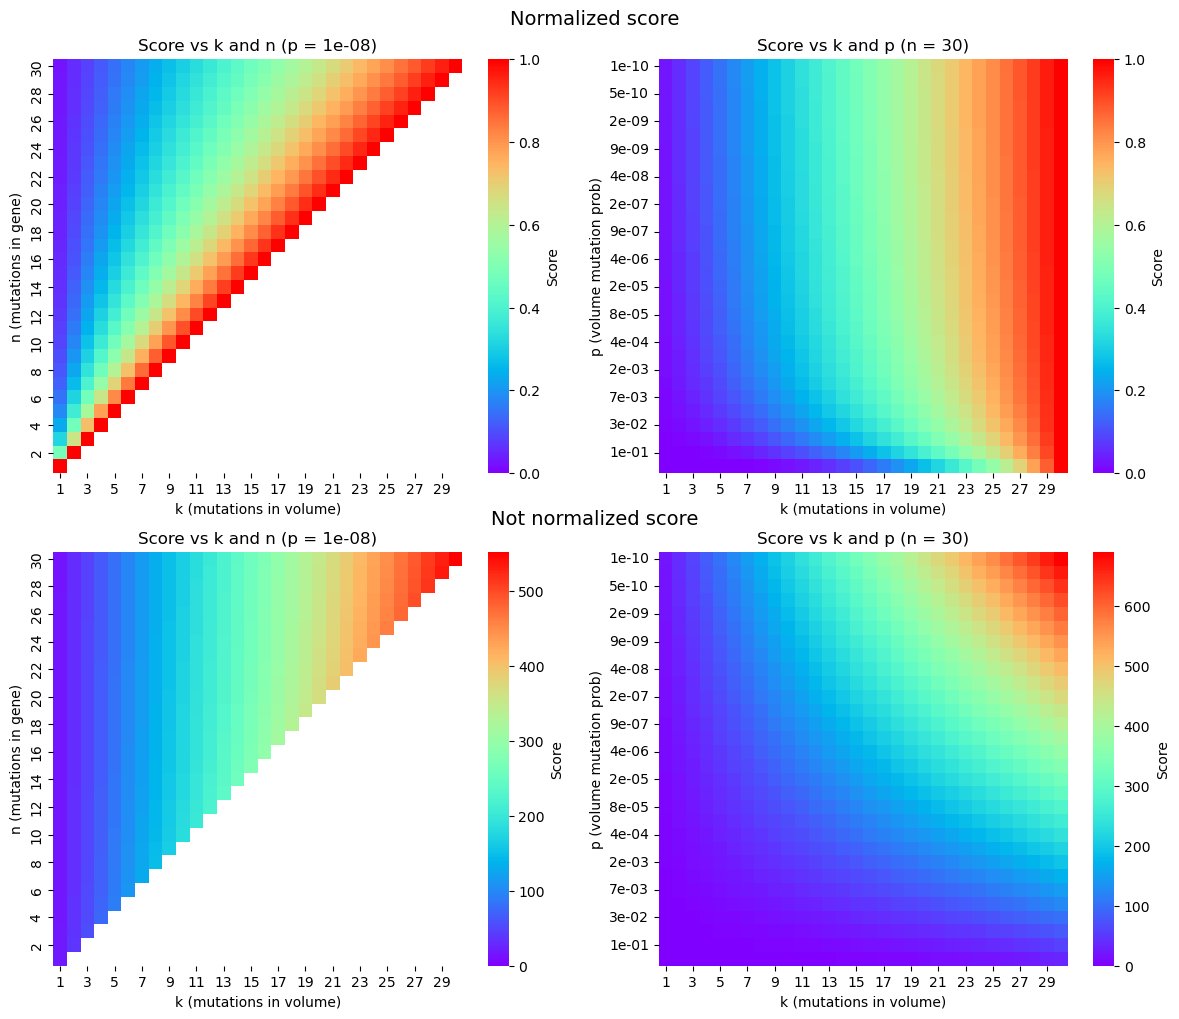

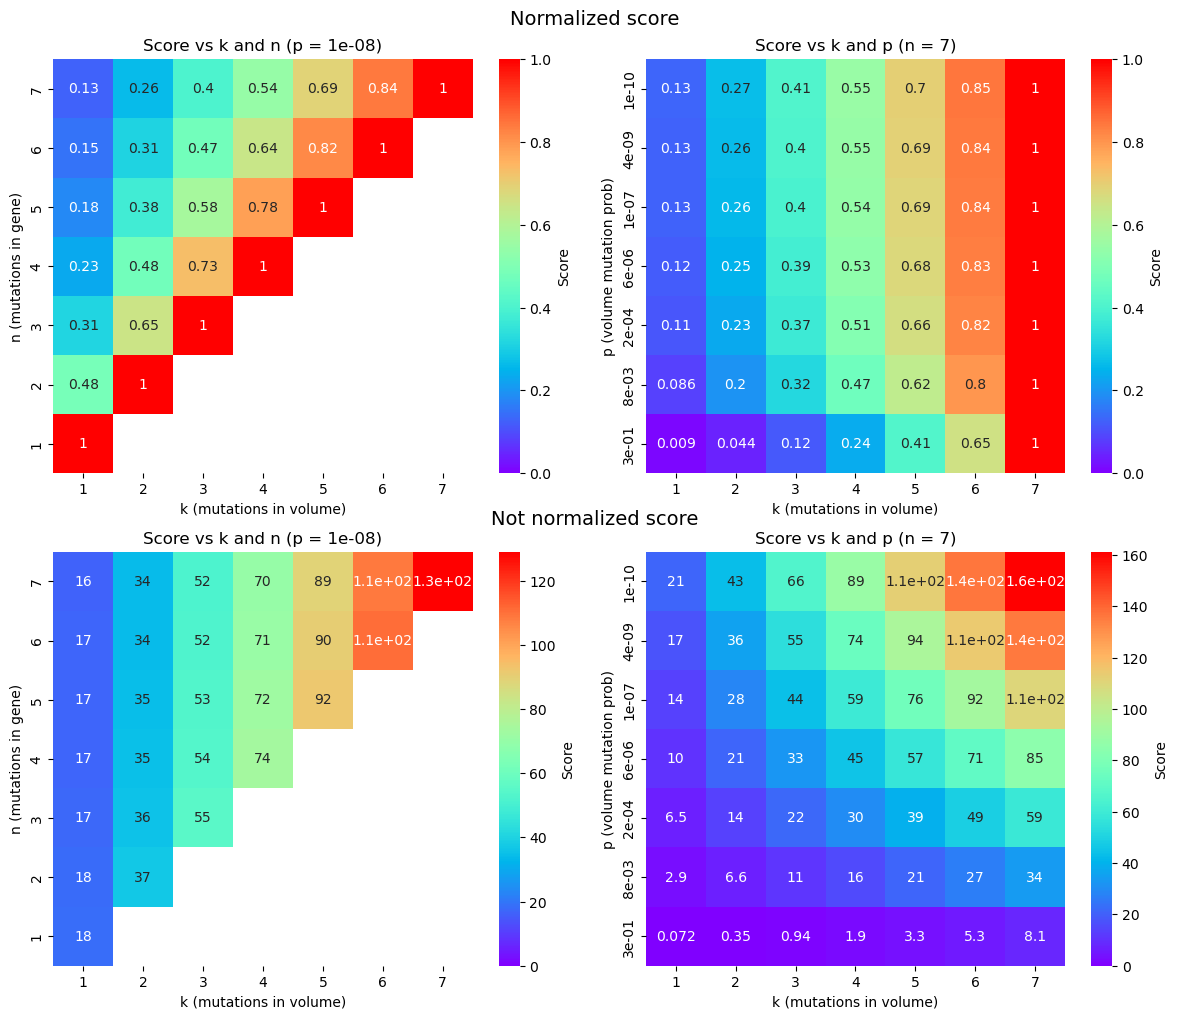

In [1061]:
plot_score_comparison(n_points=30, n_fixed=30, p_fixed=1e-8, figsize=(12, 10))
plot_score_comparison(n_points=7, n_fixed=7, p_fixed=1e-8, figsize=(12, 10), annot=True)

## Other comparison

In [648]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene", "Pos_top_vol"]].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)

In [654]:
SUBDIR = "review"
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"


RUN = "run_control_2025-03-21_11-24-24"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_norm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)


RUN = "run_notnorm_2025-03-26_10-58-45"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_notnorm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_control_2025-03-21_11-24-24/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


In [655]:
seq_df = pd.read_table("/workspace/nobackup/scratch/oncodrive3d/datasets_mane_240506/seq_for_mut_prob.tsv")

gene_to_seq = seq_df.set_index('Gene')['Seq'].to_dict()
df_norm['Seq_Length'] = df_norm['Gene'].map(lambda x: len(gene_to_seq[x]) if x in gene_to_seq else np.nan)
df_notnorm['Seq_Length'] = df_notnorm['Gene'].map(lambda x: len(gene_to_seq[x]) if x in gene_to_seq else np.nan)

In [656]:
cols = ["Gene", "Cohort", "index", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_gene", "Mut_in_top_vol", "Pos_top_vol", "Seq_Length"]
df_norm = df_norm.rename(columns={col:f"{col}_1" for col in df_norm.columns if col not in ["Cohort", "Gene"]})
df_notnorm = df_notnorm.rename(columns={col:f"{col}_0" for col in df_notnorm.columns if col not in ["Cohort", "Gene"]})
df = df_norm.merge(df_notnorm, on=["Cohort", "Gene"], how="outer")
df = df.rename(columns={
    "Seq_Length_1":"Seq_Length",
    "Mut_in_gene_1":"Mut_in_gene",
    "Score_obs_sim_top_vol_1":"Score_1",
    "Score_obs_sim_top_vol_0":"Score_0"})

print(df["pval_1"].corr(df["Mut_in_gene"]))
print(df["pval_0"].corr(df["Mut_in_gene"]))

0.3039247133446716
0.25926810224200164


In [658]:
df.corr()[["Rank_1", "pval_1", "Score_1", "Rank_0", "pval_0", "Score_0"]].iloc[[0,1,3,4,10,11,13,14,5,9]]

Rank_1    pval_1   Score_1    Rank_0    pval_0   Score_0
Rank_1            1.000000  0.719438 -0.175228  0.952911  0.638143 -0.148386
pval_1            0.719438  1.000000 -0.263474  0.670827  0.903112 -0.224964
Score_1          -0.175228 -0.263474  1.000000 -0.172022 -0.254600  0.987747
Mut_in_top_vol_1 -0.032633 -0.090684  0.931941 -0.029755 -0.082111  0.923753
Rank_0            0.952911  0.670827 -0.172022  1.000000  0.682648 -0.156527
pval_0            0.638143  0.903112 -0.254600  0.682648  1.000000 -0.238267
Score_0          -0.148386 -0.224964  0.987747 -0.156527 -0.238267  1.000000
Mut_in_top_vol_0 -0.038645 -0.096134  0.935521 -0.036245 -0.087971  0.928159
Mut_in_gene       0.312854  0.303925  0.264778  0.277379  0.259268  0.274495
Seq_Length       -0.049225  0.059171 -0.015803 -0.067848  0.030184 -0.012833

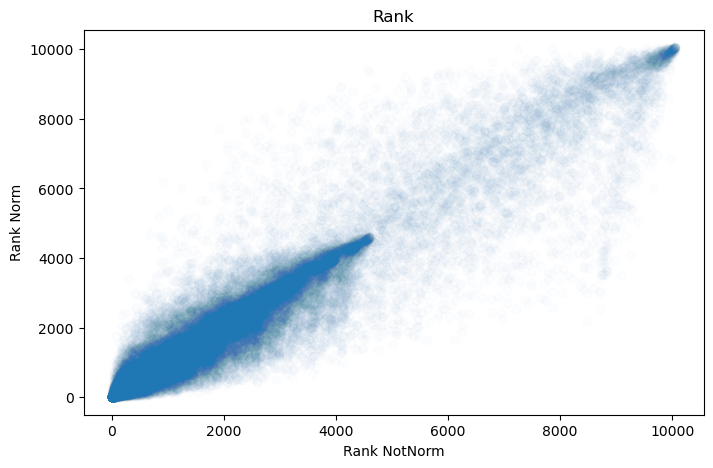

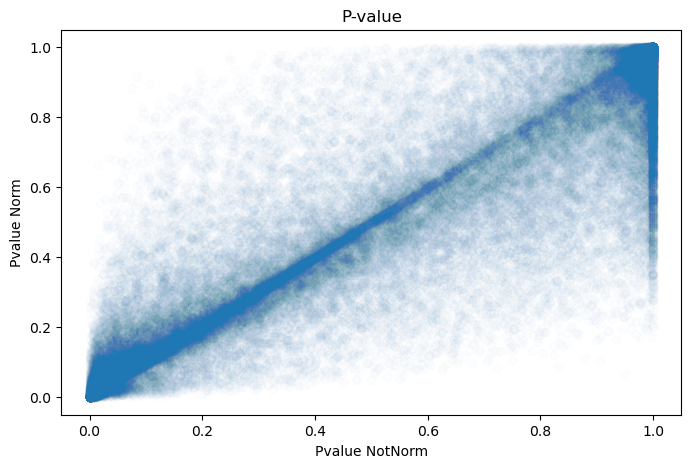

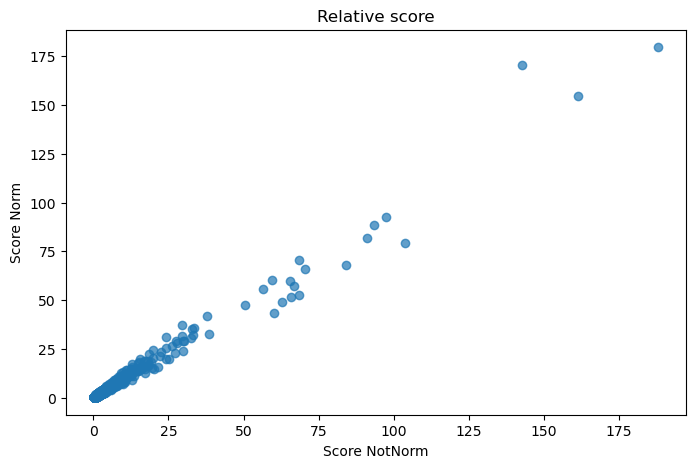

In [663]:
# Create DataFrame
df_plot = df.copy()
df_plot.pval_1 = df.pval_1.replace(0, 1e-5)
df_plot.pval_0 = df.pval_0.replace(0, 1e-5)

plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Rank_0"], df_plot["Rank_1"], alpha=0.01, label=name)
plt.xlabel("Rank NotNorm")
plt.ylabel("Rank Norm")
plt.title("Rank")
plt.show()

df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["pval_0"], df_plot["pval_1"], alpha=0.01, label=name)
plt.xlabel("Pvalue NotNorm")
plt.ylabel("Pvalue Norm")
plt.title("P-value")
plt.show()


df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.title("Relative score")
plt.xlabel("Score NotNorm")
plt.ylabel("Score Norm")
plt.scatter(df_plot["Score_0"], df_plot["Score_1"], alpha=0.7)
plt.show()

## Comparison in one cohort

In [ ]:
cohort = "TCGA_WXS_BLCA"

from itertools import product

import daiquiri
import numpy as np
import json


def get_unif_gene_miss_prob(size):
    """
    Get a uniformly distributed gene missense mutation 
    probability vector.
    """
    
    vector = np.ones(size)
    vector[0] = 0
    
    return vector / sum(vector)


def mut_rate_vec_to_dict(mut_rate):
    """
    Convert the vector of mut mut_rate of 96 channels to a dictionary of 192 
    items: the keys are mutations in trinucleotide context (e.g., "ACA>A") 
    and values are the corresponding mut rate (frequency of mut normalized 
    for the nucleotide content).
    """
    
    cb  = dict(zip('ACGT', 'TGCA'))
    mut_rate_dict = {}
    i = 0
    for ref in ['C', 'T']:
        for alt in cb.keys():
            if ref == alt:
                continue
            else:
                for p in product(cb.keys(), repeat=2):
                    mut = f"{p[0]}{ref}{p[1]}>{alt}"
                    cmut = f"{cb[p[1]]}{cb[ref]}{cb[p[0]]}>{cb[alt]}"
                    mut_rate_dict[mut] = mut_rate[i]
                    mut_rate_dict[cmut] = mut_rate[i]
                    i +=1
                    
    return mut_rate_dict


def get_codons(dna_seq):
    """
    Get the list of codons from a DNA sequence.
    """
    
    return [dna_seq[i:i+3] for i in [n*3 for n in range(int(len(dna_seq) / 3))]]


def translate_dna_to_prot(dna_seq, gencode):
    """
    Translate a DNA sequence into amino acid sequence.
    """
    
    return "".join([gencode[codon] for codon in get_codons(dna_seq)])


def codons_trinucleotide_context(lst_contexts):
    
    return list(zip(lst_contexts[::3], lst_contexts[1::3], lst_contexts[2::3]))


# TODO: doc function

def get_miss_mut_prob(dna_seq, 
                      dna_tricontext, 
                      mut_rate_dict, 
                      mutability=False, 
                      get_probability=True, 
                      mut_start_codon=False):
    """
    Generate a list including the probabilities that the 
    codons can mutate resulting into a missense mutations.
    
    Arguments
    ---------
    dna_seq: str
        Sequence of DNA
    mut_rate_dict: dict
        Mutation rate probability as values and the 96 possible
        trinucleotide contexts as keys
    gencode: dict
        Nucleotide as values and codons as keys
        
    Returns
    -------
    missense_prob_vec: list
        List of probabilities (one for each codon or prot res) 
        of a missense mutation  
    """

    # Initialize
    gencode = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'}

    # Get all codons of the seq
    #logger.debug("Getting codons of seq..")
    codons = get_codons(dna_seq)
    missense_prob_vec = []
    
    # Get the trinucleotide context as list of tuples of 3 elements corresponding to each codon   
    #logger.debug("Getting tri context seq..")                               
    tricontext = codons_trinucleotide_context(dna_tricontext.split(","))
    
    # Iterate through codons and get prob of missense based on context
    for c in range(len(codons)):
        missense_prob = 0
        codon = codons[c]
        aa = gencode[codon]         
        trinucl0, trinucl1, trinucl2  = tricontext[c]

        # Iterate through the possible contexts of a missense mut
        for i, trinucl in enumerate([trinucl0, trinucl1, trinucl2]):
            ref = trinucl[1]
            aa = gencode[codon]

            # Iterate through the possible alt 
            for alt in "ACGT":
                if alt != ref:         
                    alt_codon = [n for n in codon]
                    alt_codon[i] = alt
                    alt_codon = "".join(alt_codon)
                    alt_aa = gencode[alt_codon]  
                    # If there is a missense mut, get prob from context and sum it
                    if alt_aa != aa and alt_aa != "_":
                        if not mutability:
                            mut = f"{trinucl}>{alt}"    # query using only the trinucleotide change
                            mut_prob = mut_rate_dict[mut] if mut in mut_rate_dict else 0                                                                 
                            missense_prob += mut_prob

                        else:
                            # TODO this has not been tested
                            cdna_pos = (c * 3) + i  # compute the cDNA position of the residue
                            if cdna_pos in mut_rate_dict:
                                missense_prob += mut_rate_dict[cdna_pos].get(alt, 0)
                            else:
                                missense_prob += 0

        missense_prob_vec.append(missense_prob)

    # Assign 0 prob to the first residue
    if mut_start_codon == False:
        missense_prob_vec[0] = 0
        
    # Convert into probabilities
    if get_probability:
        missense_prob_vec = np.array(missense_prob_vec) / sum(missense_prob_vec)
    
    return list(missense_prob_vec)


def get_miss_mut_prob_dict(mut_rate_dict, seq_df, mutability=False, mutability_config=None):
    """
    Given a dictionary of mut rate in 96 contexts (mut profile) and a 
    dataframe including Uniprot ID, HUGO symbol and DNA sequences, 
    get a dictionary with UniprotID-Fragment as keys and corresponding 
    vectors of missense mutation probabilities as values.
    """

    miss_prob_dict = {}

    if mutability:
        # TODO if the execution time of this step is too long we could
        # parallelize all these loops so that each gene is done in parallel

        # Process any Protein/fragment in the sequence df
        for _, row in seq_df.iterrows():
            # Mutabilities
            mutability_dict = Mutabilities(row.Uniprot_ID, row.Chr, row.Exons_coord, len(row.Seq_dna), row.Reverse_strand, mutability_config).mutabilities_by_pos
            miss_prob_dict[f"{row.Uniprot_ID}-F{row.F}"] = get_miss_mut_prob(row.Seq_dna, row.Tri_context, mutability_dict, mutability=True)

    else:
        # Process any Protein/fragment in the sequence df
        for _, row in seq_df.iterrows():
            miss_prob_dict[f"{row.Uniprot_ID}-F{row.F}"] = get_miss_mut_prob(row.Seq_dna, row.Tri_context, mut_rate_dict)
    
    return miss_prob_dict


def get_cmap(cmap_path, uniprot_id, af_f, cmap_prob_thr=0.5):
    
    cmap_complete_path = f"{cmap_path}/{uniprot_id}-F{af_f}.npy"
    cmap = np.load(cmap_complete_path) 
    cmap = cmap > cmap_prob_thr
    cmap = cmap.astype(int)
    
    return cmap


def get_vol_miss_prob(gene, cmap_path, miss_prob_dict, seq_df):
    
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    uniprot_id = seq_df_gene['Uniprot_ID'].values[0]
    af_f = seq_df_gene['F'].values[0]
    
    cmap = get_cmap(cmap_path, uniprot_id, af_f)
    gene_miss_prob = np.array(miss_prob_dict[f"{uniprot_id}-F{af_f}"])
    vol_missense_mut_prob = np.dot(cmap, gene_miss_prob)
    
    return vol_missense_mut_prob
    

cmap_path = "/workspace/nobackup/scratch/oncodrive3d/datasets_mane_240506/prob_cmaps"
mut_profile_path = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/mut_profile/{cohort}.sig.json"
mut_profile = json.load(open(mut_profile_path, encoding="utf-8"))
miss_prob_dict = get_miss_mut_prob_dict(mut_rate_dict=mut_profile, seq_df=seq_df)

vol_miss_prob_dict = {}
for gene in tqdm(df.Gene.unique()):
    vol_miss_prob_dict[gene] =  get_vol_miss_prob(gene, cmap_path, miss_prob_dict, seq_df)

In [1027]:
cohort = "TCGA_WXS_BLCA"
SUBDIR = "review"
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"

RUN = "run_control_2025-03-21_11-24-24"
path = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}/{cohort}/{cohort}.3d_clustering_genes.csv"
df_norm = pd.read_csv(path)

RUN = "run_notnorm_2025-03-26_10-58-45"
path = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}/{cohort}/{cohort}.3d_clustering_genes.csv"
df_notnorm = pd.read_csv(path)

In [1028]:
seq_df = pd.read_table("/workspace/nobackup/scratch/oncodrive3d/datasets_mane_240506/seq_for_mut_prob.tsv")

gene_to_seq = seq_df.set_index('Gene')['Seq'].to_dict()
df_norm['Seq_Length'] = df_norm['Gene'].map(lambda x: len(gene_to_seq[x]) if x in gene_to_seq else np.nan)
df_notnorm['Seq_Length'] = df_notnorm['Gene'].map(lambda x: len(gene_to_seq[x]) if x in gene_to_seq else np.nan)

In [1029]:
cols = ["Gene", "index", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_gene", "Mut_in_top_vol", "Pos_top_vol", "Seq_Length"]

df_norm = df_norm.reset_index()[cols].rename(columns={"index": "Rank"}).dropna(subset="pval")
df_norm = df_norm.rename(columns={col:f"{col}_1" for col in df_norm.columns if col != "Gene"})

df_notnorm = df_notnorm.reset_index()[cols].rename(columns={"index": "Rank"}).dropna(subset="pval")
df_notnorm = df_notnorm.rename(columns={col:f"{col}_0" for col in df_notnorm.columns if col != "Gene"})

df = df_norm.merge(df_notnorm, on="Gene", how="outer")
df

Gene  Rank_1  pval_1  qval_1  Score_obs_sim_top_vol_1  Mut_in_gene_1  \
0      PIK3CA       0     0.0     0.0                18.554445             87   
1       FGFR3       1     0.0     0.0                15.401595             63   
2        TP53       2     0.0     0.0                14.570084            155   
3       FBXW7       3     0.0     0.0                 7.222402             20   
4       ERBB2       4     0.0     0.0                 7.057737             50   
...       ...     ...     ...     ...                      ...            ...   
2679   KLHDC2    2679     1.0     1.0                 0.459673              7   
2680  CYP11B2    2680     1.0     1.0                 0.441947             11   
2681    FABP9    2681     1.0     1.0                 0.441689              5   
2682    OR4K5    2682     1.0     1.0                 0.429416             11   
2683  SLC10A2    2683     1.0     1.0                 0.407987              8   

      Mut_in_top_vol_1  Pos_top_vol_1  Seq_Length_1  Rank_0  pval_0  qval_0  \
0                 45.0          542.0        1068.0       0     0.0     0.0   
1                 34.0          249.0         806.0       1     0.0     0.0   
2                 49.0          245.0         393.0       2     0.0     0.0   
3                 15.0          505.0         707.0       5     0.0     0.0   
4                 19.0          310.0        1255.0       4     0.0     0.0   
...                ...            ...           ...     ...     ...     ...   
2679               2.0          241.0         406.0    2682     1.0     1.0   
2680               2.0          317.0         503.0    2677     1.0     1.0   
2681               2.0          127.0         132.0    2673     1.0     1.0   
2682               2.0          159.0         323.0    2679     1.0     1.0   
2683               2.0          256.0         348.0    2683     1.0     1.0   

      Score_obs_sim_top_vol_0  Mut_in_gene_0  Mut_in_top_vol_0  Pos_top_vol_0  \
0                   18.348227             87              47.0          545.0   
1                   15.576814             63              34.0          249.0   
2                   13.527937            155              45.0          249.0   
3                    6.211048             20              15.0          505.0   
4                    6.738814             50              19.0          310.0   
...                       ...            ...               ...            ...   
2679                 0.363414              7               1.0          347.0   
2680                 0.421241             11               2.0          317.0   
2681                 0.456938              5               2.0          127.0   
2682                 0.409751             11               2.0          159.0   
2683                 0.356713              8               1.0           30.0   

      Seq_Length_0  
0           1068.0  
1            806.0  
2            393.0  
3            707.0  
4           1255.0  
...            ...  
2679         406.0  
2680         503.0  
2681         132.0  
2682         323.0  
2683         348.0  

[2684 rows x 17 columns]

In [1030]:
def detected_norm_notnorm(x):
    
    if (x["qval_1"] < 0.01) & (x["qval_0"] < 0.01):
        return "C_01"
    
    elif (x["qval_1"] > 0.01) & (x["qval_0"] < 0.01):
        return "C_0"

    elif (x["qval_0"] > 0.01) & (x["qval_1"] < 0.01):
        return "C_1"
    
    else:
        return "None"
    
df["Detected"] = df.apply(lambda x: detected_norm_notnorm(x), axis=1)
top_genes = df.Gene.values[:30]
df

Gene  Rank_1  pval_1  qval_1  Score_obs_sim_top_vol_1  Mut_in_gene_1  \
0      PIK3CA       0     0.0     0.0                18.554445             87   
1       FGFR3       1     0.0     0.0                15.401595             63   
2        TP53       2     0.0     0.0                14.570084            155   
3       FBXW7       3     0.0     0.0                 7.222402             20   
4       ERBB2       4     0.0     0.0                 7.057737             50   
...       ...     ...     ...     ...                      ...            ...   
2679   KLHDC2    2679     1.0     1.0                 0.459673              7   
2680  CYP11B2    2680     1.0     1.0                 0.441947             11   
2681    FABP9    2681     1.0     1.0                 0.441689              5   
2682    OR4K5    2682     1.0     1.0                 0.429416             11   
2683  SLC10A2    2683     1.0     1.0                 0.407987              8   

      Mut_in_top_vol_1  Pos_top_vol_1  Seq_Length_1  Rank_0  pval_0  qval_0  \
0                 45.0          542.0        1068.0       0     0.0     0.0   
1                 34.0          249.0         806.0       1     0.0     0.0   
2                 49.0          245.0         393.0       2     0.0     0.0   
3                 15.0          505.0         707.0       5     0.0     0.0   
4                 19.0          310.0        1255.0       4     0.0     0.0   
...                ...            ...           ...     ...     ...     ...   
2679               2.0          241.0         406.0    2682     1.0     1.0   
2680               2.0          317.0         503.0    2677     1.0     1.0   
2681               2.0          127.0         132.0    2673     1.0     1.0   
2682               2.0          159.0         323.0    2679     1.0     1.0   
2683               2.0          256.0         348.0    2683     1.0     1.0   

      Score_obs_sim_top_vol_0  Mut_in_gene_0  Mut_in_top_vol_0  Pos_top_vol_0  \
0                   18.348227             87              47.0          545.0   
1                   15.576814             63              34.0          249.0   
2                   13.527937            155              45.0          249.0   
3                    6.211048             20              15.0          505.0   
4                    6.738814             50              19.0          310.0   
...                       ...            ...               ...            ...   
2679                 0.363414              7               1.0          347.0   
2680                 0.421241             11               2.0          317.0   
2681                 0.456938              5               2.0          127.0   
2682                 0.409751             11               2.0          159.0   
2683                 0.356713              8               1.0           30.0   

      Seq_Length_0 Detected  
0           1068.0     C_01  
1            806.0     C_01  
2            393.0     C_01  
3            707.0     C_01  
4           1255.0     C_01  
...            ...      ...  
2679         406.0     None  
2680         503.0     None  
2681         132.0     None  
2682         323.0     None  
2683         348.0     None  

[2684 rows x 18 columns]

In [1031]:
df = df.rename(columns={
    "Score_obs_sim_top_vol_1":"Score_1",
    "Score_obs_sim_top_vol_0":"Score_0"})
df.corr()[["Rank_1", "pval_1", "Score_1", "Rank_0", "pval_0", "Score_0"]].iloc[[0,1,3,5,8,9,11,13,7,5]]

Rank_1    pval_1   Score_1    Rank_0    pval_0   Score_0
Rank_1            1.000000  0.999615 -0.494315  0.830976  0.828957 -0.433369
pval_1            0.999615  1.000000 -0.500064  0.832312  0.829751 -0.438755
Score_1          -0.494315 -0.500064  1.000000 -0.474467 -0.467602  0.976891
Mut_in_top_vol_1 -0.202959 -0.208683  0.900253 -0.182207 -0.176369  0.890075
Rank_0            0.830976  0.832312 -0.474467  1.000000  0.995538 -0.501110
pval_0            0.828957  0.829751 -0.467602  0.995538  1.000000 -0.493218
Score_0          -0.433369 -0.438755  0.976891 -0.501110 -0.493218  1.000000
Mut_in_top_vol_0 -0.211882 -0.217623  0.907255 -0.195071 -0.187374  0.899584
Seq_Length_1      0.220891  0.220981 -0.078565  0.146499  0.148682 -0.058563
Mut_in_top_vol_1 -0.202959 -0.208683  0.900253 -0.182207 -0.176369  0.890075

In [1032]:
df[:20]

Gene  Rank_1  pval_1    qval_1    Score_1  Mut_in_gene_1  \
0    PIK3CA       0  0.0000  0.000000  18.554445             87   
1     FGFR3       1  0.0000  0.000000  15.401595             63   
2      TP53       2  0.0000  0.000000  14.570084            155   
3     FBXW7       3  0.0000  0.000000   7.222402             20   
4     ERBB2       4  0.0000  0.000000   7.057737             50   
5      KRAS       5  0.0000  0.000000   6.159702             16   
6      RXRA       6  0.0000  0.000000   5.875343             18   
7      HRAS       7  0.0000  0.000000   5.498907             15   
8     SF3B1       8  0.0000  0.000000   4.859567             20   
9    NFE2L2       9  0.0000  0.000000   4.738798             25   
10   CREBBP      10  0.0000  0.000000   4.308101             24   
11    GNA13      11  0.0000  0.000000   4.248230              9   
12    ERCC2      12  0.0000  0.000000   4.223996             30   
13  C3orf70      13  0.0000  0.000000   3.881935             14   
14     SCEL      14  0.0000  0.000000   3.240174              5   
15     CUL1      15  0.0000  0.000000   2.914902             16   
16      AHR      16  0.0000  0.000000   2.731651             19   
17   DIAPH2      17  0.0000  0.000000   2.628188             18   
18     KLF5      18  0.0001  0.072462   2.836375             13   
19    RARS2      19  0.0001  0.072462   2.660729              6   

    Mut_in_top_vol_1  Pos_top_vol_1  Seq_Length_1  Rank_0  pval_0    qval_0  \
0               45.0          542.0        1068.0       0  0.0000  0.000000   
1               34.0          249.0         806.0       1  0.0000  0.000000   
2               49.0          245.0         393.0       2  0.0000  0.000000   
3               15.0          505.0         707.0       5  0.0000  0.000000   
4               19.0          310.0        1255.0       4  0.0000  0.000000   
5               13.0           59.0         188.0       3  0.0000  0.000000   
6               13.0          427.0         462.0       6  0.0000  0.000000   
7               13.0           13.0         189.0       7  0.0000  0.000000   
8               10.0          902.0        1304.0       8  0.0000  0.000000   
9               11.0           31.0         605.0       9  0.0000  0.000000   
10               9.0         1484.0        2442.0      13  0.0000  0.000000   
11               8.0          200.0         377.0      12  0.0000  0.000000   
12              13.0           75.0         760.0      11  0.0000  0.000000   
13               8.0            6.0         250.0      10  0.0000  0.000000   
14               4.0          189.0         688.0      14  0.0000  0.000000   
15               7.0          485.0         776.0      16  0.0000  0.000000   
16               7.0          383.0         848.0      22  0.0003  0.198483   
17               6.0          284.0        1101.0      17  0.0000  0.000000   
18               6.0          414.0         457.0      20  0.0002  0.144924   
19               5.0            6.0         578.0      21  0.0003  0.198483   

      Score_0  Mut_in_gene_0  Mut_in_top_vol_0  Pos_top_vol_0  Seq_Length_0  \
0   18.348227             87              47.0          545.0        1068.0   
1   15.576814             63              34.0          249.0         806.0   
2   13.527937            155              45.0          249.0         393.0   
3    6.211048             20              15.0          505.0         707.0   
4    6.738814             50              19.0          310.0        1255.0   
5    6.801527             16              14.0           12.0         188.0   
6    5.842422             18              13.0          427.0         462.0   
7    5.213877             15              13.0           13.0         189.0   
8    4.804373             20              10.0          902.0        1304.0   
9    4.299217             25              11.0           31.0         605.0   
10   3.445671             24               9.0         1484.0        2

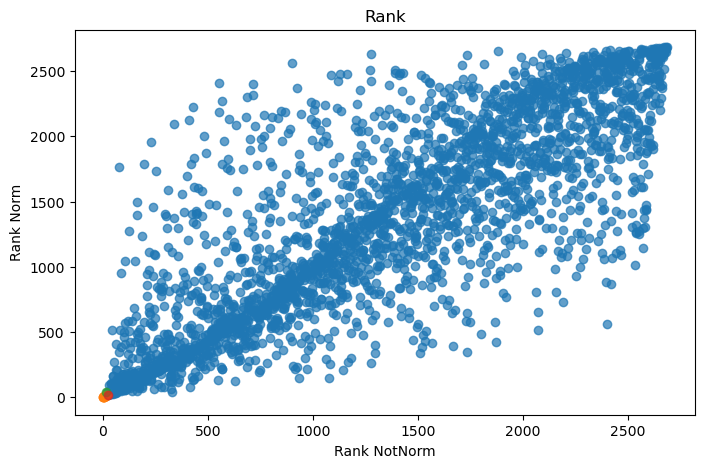

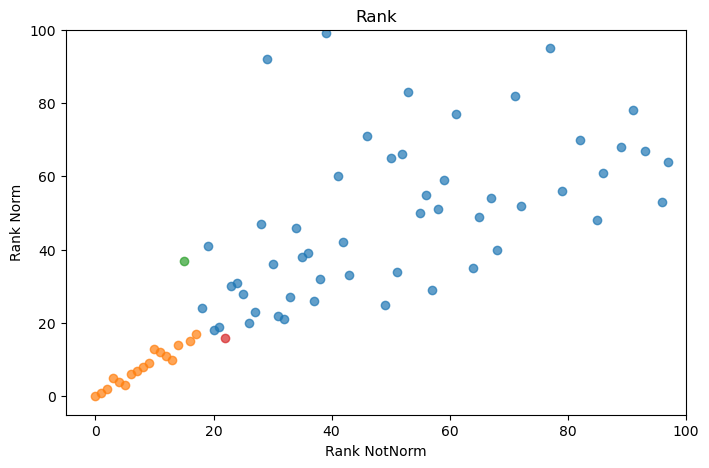

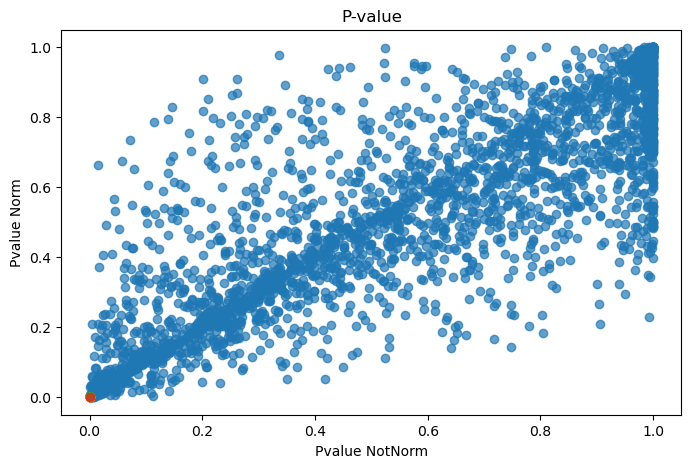

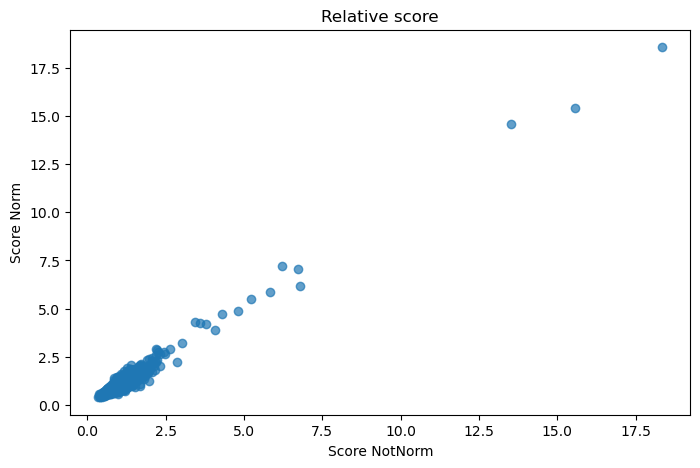

In [786]:
# Create DataFrame
df_plot = df.copy()
df_plot.pval_1 = df.pval_1.replace(0, 1e-5)
df_plot.pval_0 = df.pval_0.replace(0, 1e-5)

plt.figure(figsize=(8, 5))
for name in ["None", "C_01", "C_0", "C_1"]:
    df_detect = df_plot[df_plot["Detected"] == name]
    plt.scatter(df_detect["Rank_0"], df_detect["Rank_1"], alpha=0.7, label=name)
plt.xlabel("Rank NotNorm")
plt.ylabel("Rank Norm")
plt.title("Rank")
plt.show()

plt.figure(figsize=(8, 5))
for name in ["None", "C_01", "C_0", "C_1"]:
    df_detect = df_plot[df_plot["Detected"] == name]
    plt.scatter(df_detect["Rank_0"], df_detect["Rank_1"], alpha=0.7, label=name)
plt.xlabel("Rank NotNorm")
plt.ylabel("Rank Norm")
plt.ylim(-5, 100)
plt.xlim(-5, 100)
plt.title("Rank")
plt.show()


df_plot = df.copy()
plt.figure(figsize=(8, 5))
for name in ["None", "C_01", "C_0", "C_1"]:
    df_detect = df_plot[df_plot["Detected"] == name]
    plt.scatter(df_detect["pval_0"], df_detect["pval_1"], alpha=0.7, label=name)
plt.xlabel("Pvalue NotNorm")
plt.ylabel("Pvalue Norm")
plt.title("P-value")
plt.show()


df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.title("Relative score")
plt.xlabel("Score NotNorm")
plt.ylabel("Score Norm")
plt.scatter(df_plot["Score_0"], df_plot["Score_1"], alpha=0.7)
plt.show()

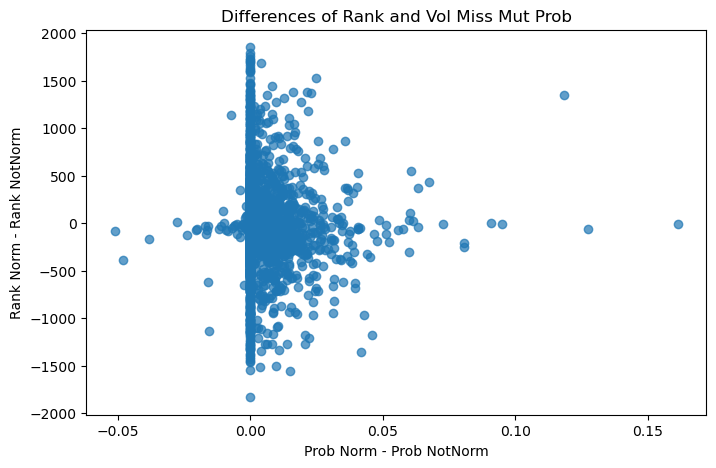

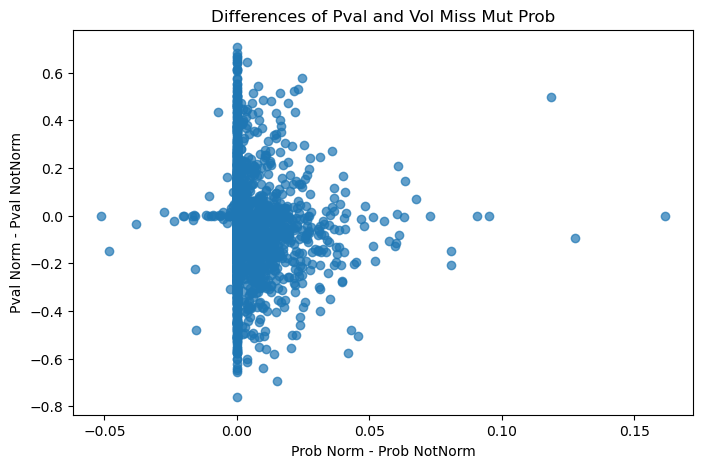

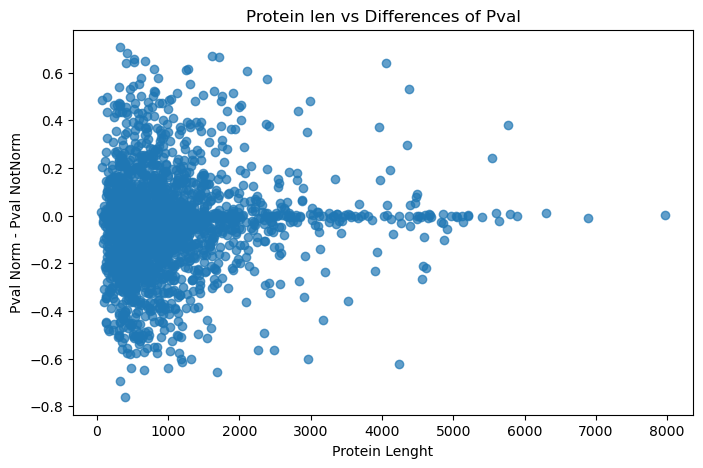

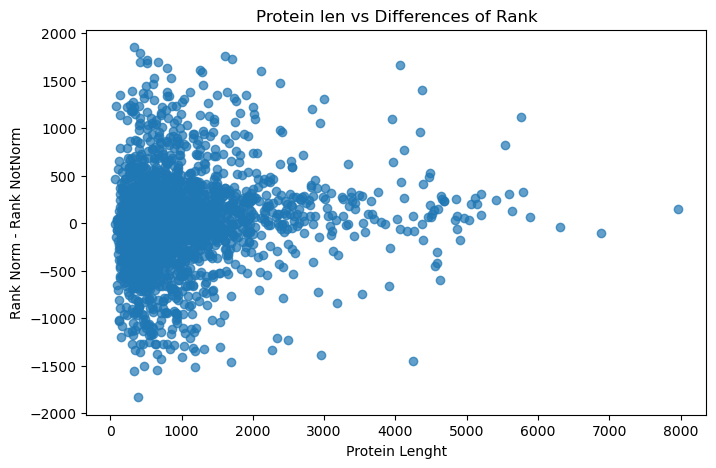

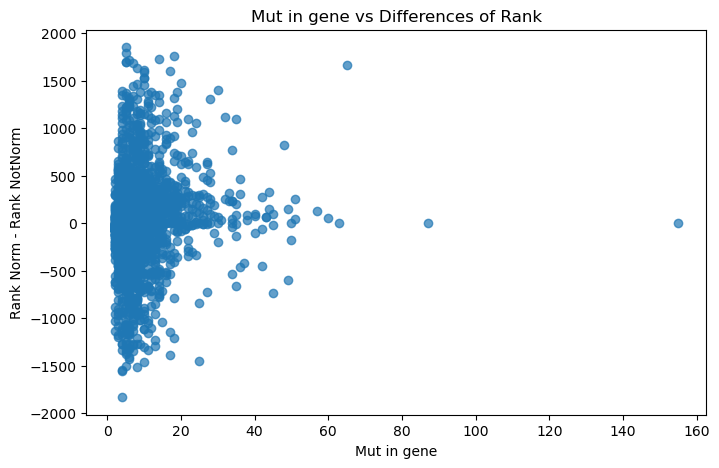

In [1034]:
def lookup_prob(gene_series, pos_series, vol_dict):
    result = []
    for gene, pos in zip(gene_series, pos_series):
        if gene in vol_dict and pd.notna(pos):
            try:
                prob_list = vol_dict[gene]
                index = int(pos) - 1
                if 0 <= index < len(prob_list):
                    result.append(prob_list[index])
                else:
                    result.append(np.nan)
            except (TypeError, IndexError):
                result.append(np.nan)
        else:
            result.append(np.nan)
    return result

df["Prob_1"] = lookup_prob(df["Gene"], df["Pos_top_vol_1"], vol_miss_prob_dict)
df["Prob_0"] = lookup_prob(df["Gene"], df["Pos_top_vol_0"], vol_miss_prob_dict)
df["Pval_diff"] = df["pval_1"] - df["pval_0"]
df["Score_diff"] = df["Score_1"] - df["Score_0"]
df["Mut_diff"] = df["Mut_in_top_vol_1"] - df["Mut_in_top_vol_0"]
df["Prob_diff"] = df["Prob_1"] - df["Prob_0"]
df["Rank_diff"] = df["Rank_1"] - df["Rank_0"]
df["Pos_dif"] = df["Pos_top_vol_1"] - df["Pos_top_vol_0"]
df["Pos_dif"] = (df["Pos_dif"] != 0).astype(int)


df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Prob_diff"], df_plot["Rank_diff"], alpha=0.7)
plt.xlabel("Prob Norm - Prob NotNorm")
plt.ylabel("Rank Norm - Rank NotNorm")
plt.title("Differences of Rank and Vol Miss Mut Prob")
plt.show()

df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Prob_diff"], df_plot["Pval_diff"], alpha=0.7)
plt.xlabel("Prob Norm - Prob NotNorm")
plt.ylabel("Pval Norm - Pval NotNorm")
plt.title("Differences of Pval and Vol Miss Mut Prob")
plt.show()

df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Seq_Length_1"], df_plot["Pval_diff"], alpha=0.7)
plt.xlabel("Protein Lenght")
plt.ylabel("Pval Norm - Pval NotNorm")
plt.title("Protein len vs Differences of Pval")
plt.show()

df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Seq_Length_1"], df_plot["Rank_diff"], alpha=0.7)
plt.xlabel("Protein Lenght")
plt.ylabel("Rank Norm - Rank NotNorm")
plt.title("Protein len vs Differences of Rank")
plt.show()

df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Mut_in_gene_0"], df_plot["Rank_diff"], alpha=0.7)
plt.xlabel("Mut in gene")
plt.ylabel("Rank Norm - Rank NotNorm")
plt.title("Mut in gene vs Differences of Rank")
plt.show()

# When there is a difference in pvalue and two different residues are selected as top, the Normalized Score has almost always preference for the one with higher probability to mutate (likely buried ones)

In [790]:
df[["Pval_diff", "Score_diff", "Prob_diff", "Rank_diff", "Pos_dif", "Mut_in_gene_0", "Seq_Length_0"]].corr()

Pval_diff  Score_diff  Prob_diff  Rank_diff   Pos_dif  \
Pval_diff       1.000000   -0.628281  -0.058000   0.957815 -0.075231   
Score_diff     -0.628281    1.000000  -0.094420  -0.687222 -0.073633   
Prob_diff      -0.058000   -0.094420   1.000000  -0.032579  0.542173   
Rank_diff       0.957815   -0.687222  -0.032579   1.000000 -0.031752   
Pos_dif        -0.075231   -0.073633   0.542173  -0.031752  1.000000   
Mut_in_gene_0   0.061558   -0.066414  -0.057794   0.134767  0.101720   
Seq_Length_0    0.076375   -0.102096  -0.149336   0.127967  0.043024   

               Mut_in_gene_0  Seq_Length_0  
Pval_diff           0.061558      0.076375  
Score_diff         -0.066414     -0.102096  
Prob_diff          -0.057794     -0.149336  
Rank_diff           0.134767      0.127967  
Pos_dif             0.101720      0.043024  
Mut_in_gene_0       1.000000      0.718544  
Seq_Length_0        0.718544      1.000000

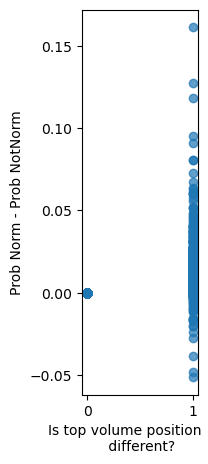

In [770]:
df_plot = df.copy()
plt.figure(figsize=(1.5, 5))
plt.scatter(df_plot["Pos_dif"], df_plot["Prob_diff"], alpha=0.7)
plt.xlabel("Is top volume position       \n different?")
plt.ylabel("Prob Norm - Prob NotNorm")
plt.show()

# As expected, the probability for equal res are the same

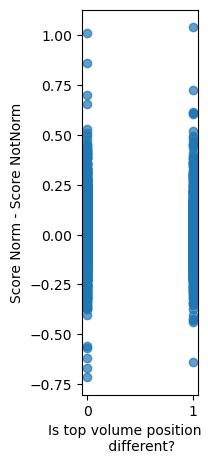

In [771]:
df_plot = df.copy()
plt.figure(figsize=(1.5, 5))
plt.scatter(df_plot["Pos_dif"], df_plot["Score_diff"], alpha=0.7)
plt.xlabel("Is top volume position       \n different?")
plt.ylabel("Score Norm - Score NotNorm")
# plt.title("Top volume position vs Differences of Pval\nbetween Genes Top Residues")
plt.show()

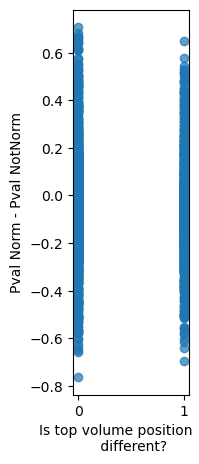

In [772]:
df_plot = df.copy()
plt.figure(figsize=(1.5, 5))
plt.scatter(df_plot["Pos_dif"], df_plot["Pval_diff"], alpha=0.7)
plt.xlabel("Is top volume position       \n different?")
plt.ylabel("Pval Norm - Pval NotNorm")
# plt.title("Top volume position vs Differences of Pval\nbetween Genes Top Residues")
plt.show()

# There seem to be large differences even on pvalues from the same volume

In [779]:
cols = ["Gene",	"Rank_1", "Rank_0", "pval_1", "pval_0", "Score_1", "Score_0", "Prob_1", "Prob_0", "Rank_diff", "Pval_diff",	"Score_diff", "Prob_diff", "Mut_diff", "Pos_dif", "Mut_in_gene_0", "Seq_Length_0"]
df = df[cols].rename(columns={"Mut_in_gene_0":"Mut_in_gene", "Seq_Length_0":"Protein_len"})
df[:50]

Gene  Rank_1  Rank_0  pval_1  pval_0    Score_1    Score_0    Prob_1  \
0     PIK3CA       0       0  0.0000  0.0000  18.554445  18.348227  0.020614   
1      FGFR3       1       1  0.0000  0.0000  15.401595  15.576814  0.016933   
2       TP53       2       2  0.0000  0.0000  14.570084  13.527937  0.052401   
3      FBXW7       3       5  0.0000  0.0000   7.222402   6.211048  0.035411   
4      ERBB2       4       4  0.0000  0.0000   7.057737   6.738814  0.015131   
5       KRAS       5       3  0.0000  0.0000   6.159702   6.801527  0.085815   
6       RXRA       6       6  0.0000  0.0000   5.875343   5.842422  0.030653   
7       HRAS       7       7  0.0000  0.0000   5.498907   5.213877  0.100183   
8      SF3B1       8       8  0.0000  0.0000   4.859567   4.804373  0.010659   
9     NFE2L2       9       9  0.0000  0.0000   4.738798   4.299217  0.021244   
10    CREBBP      10      13  0.0000  0.0000   4.308101   3.445671  0.012022   
11     GNA13      11      12  0.0000  0.0000   4.248230   3.593334  0.072288   
12     ERCC2      12      11  0.0000  0.0000   4.223996   3.798720  0.033750   
13   C3orf70      13      10  0.0000  0.0000   3.881935   4.079504  0.022259   
14      SCEL      14      14  0.0000  0.0000   3.240174   3.013151  0.011696   
15      CUL1      15      16  0.0000  0.0000   2.914902   2.626562  0.028901   
16       AHR      16      22  0.0000  0.0003   2.731651   2.256465  0.026430   
17    DIAPH2      17      17  0.0000  0.0000   2.628188   2.471848  0.015399   
18      KLF5      18      20  0.0001  0.0002   2.836375   2.230864  0.046168   
19     RARS2      19      21  0.0001  0.0003   2.660729   2.328627  0.043090   
20      ZEB2      20      26  0.0001  0.0007   2.460544   2.052863  0.014213   
21    CDKN2A      21      32  0.0002  0.0013   2.907781   2.180851  0.205989   
22    PAXIP1      22      31  0.0002  0.0012   2.365844   1.960361  0.024401   
23    NPEPPS      23      27  0.0002  0.0008   2.279657   2.062845  0.026958   
24     SOX17      24      18  0.0004  0.0001   2.744397   2.453350  0.014565   
25   SMARCA2      25      49  0.0004  0.0053   2.022123   1.665124  0.017699   
26  C12orf43      26      37  0.0006  0.0023   2.608253   2.181241  0.049476   
27    ZNF587      27      33  0.0008  0.0014   2.260565   2.063837  0.030859   
28    NHLRC1      28      25  0.0009  0.0005   2.218735   2.193549  0.047473   
29    PCDHB8      29      57  0.0010  0.0077   2.109920   1.704057  0.039470   
30    PIK3CB      30      23  0.0010  0.0004   2.045720   2.025676  0.017100   
31       SF1      31      24  0.0012  0.0005   2.333141   2.231857  0.018475   
32     RGPD8      32      38  0.0013  0.0024   2.327964   1.908060  0.012069   
33     ASXL2      33      43  0.0015  0.0030   1.997868   1.763179  0.008977   
34     EP300      34      51  0.0017  0.0058   1.877186   1.626589  0.009343   
35      KAT8      35      64  0.0022  0.0098   2.031843   1.704900  0.054697   
36  MAPK8IP1      36      30  0.0031  0.0011   2.209824   2.081922  0.014298   
37     TFPI2      37      15  0.0033  0.0000   2.242467   2.861180  0.026118   
38    TTC39C      38      35  0.0034  0.0019   2.210042   2.160002  0.026117   
39     PCARE      39      36  0.0036  0.0021   2.082915   1.957871  0.005335   
40    SLC5A5      40      68  0.0036  0.0119   1.885397   1.638738  0.042437   
41    CFAP46      41      19  0.0039  0.0001   2.024320   2.307535  0.003305   
42      RHOA      42      42  0.0047  0.0030   1.923635   1.981273  0.073196   
43    HOXA13      43     330  0.0049  0.1120   2.080164   1.381902  0.068387   
44     TRAK2      44     163  0.0051  0.0445   1.818246   1.453250  0.023569   
45  ALDH16A1      45     136  0.0055  0.0360   1.748023   1.443164  0.044434   
46     MROH5      46      34  0.0056  0.0014   1.854559   1.898040  0.012048   
47    KIF26A      47      28  0.0061  0.0009   2.013073   2.129382  0.003121   
48     F2RL3      48      85  0.0070  0.0163   2.104304   1.672105  0.068949   
49    NT

### Use pos result

In [919]:
df.sort_values("Score_0", ascending=False)[:60]

Gene   Pos  Mut_in_gene   Score_1  Score_obs_sim_1  pval_1  Rank_1  \
13993   PIK3CA   545           87  0.381449        18.137633     0.0       0   
13992   PIK3CA   542           87  0.348651        18.554445     0.0       1   
6880     FGFR3   248           63  0.386692        13.979033     0.0       0   
6879     FGFR3   249           63  0.381320        15.401595     0.0       1   
18899     TP53   241          155  0.151702        11.947984     0.0       0   
13994   PIK3CA   546           87  0.206456        11.793035     0.0       2   
18897     TP53   242          155  0.135561        13.009087     0.0       2   
18896     TP53   273          155  0.150665        13.338605     0.0       1   
18895     TP53   248          155  0.125179        13.554702     0.0       4   
18893     TP53   249          155  0.124490        14.154236     0.0       5   
18898     TP53   246          155  0.126794        12.996948     0.0       3   
18891     TP53   245          155  0.122615        14.570084     0.0       6   
18892     TP53   281          155  0.110964        14.277052     0.0       8   
6147     ERBB2   310           50  0.233987         7.057737     0.0       0   
18894     TP53   282          155  0.114135        14.133929     0.0       7   
6881     FGFR3   373           63  0.136879         5.954896     0.0       2   
18900     TP53   275          155  0.082179        11.343094     0.0      10   
18901     TP53   280          155  0.083675        11.168047     0.0       9   
6751     FBXW7   505           20  0.608114         7.222402     0.0       0   
9937      KRAS    61           16  0.697163         5.520930     0.0       1   
15893     RXRA   427           18  0.580162         5.875343     0.0       0   
16519    SF3B1   902           20  0.367556         4.859567     0.0       0   
9938      KRAS    12           16  0.767578         5.286724     0.0       0   
6883     FGFR3   370           63  0.119494         5.509480     0.0       3   
6882     FGFR3   371           63  0.118914         5.753876     0.0       4   
18902     TP53   283          155  0.068727         9.790293     0.0      11   
6752     FBXW7   465           20  0.477474         6.254667     0.0       1   
9936      KRAS    13           16  0.675347         5.873618     0.0       2   
6753     FBXW7   479           20  0.429192         5.993225     0.0       2   
8509      HRAS    12           15  0.747195         4.847671     0.0       0   
18904     TP53   132          155  0.059455         9.219389     0.0      14   
12138   NFE2L2    31           25  0.283861         4.738798     0.0       0   
18905     TP53   278          155  0.059950         9.048476     0.0      13   
18903     TP53   285          155  0.062955         9.237610     0.0      12   
16520    SF3B1   862           20  0.310810         4.479266     0.0       1   
6225     ERCC2    75           30  0.255683         4.223996     0.0       0   
4171    CREBBP  1484           24  0.243803         4.308101     0.0       0   
9935      KRAS    59           16  0.657777         6.159702     0.0       3   
8508      HRAS    13           15  0.737470         5.498907     0.0       1   
16522    SF3B1   903           20  0.273943         4.193385     0.0       2   
6756     FBXW7   520           20  0.339540         5.240368     0.0       4   
6754     FBXW7   517           20  0.370359         5.453672     0.0       3   
2375   C3orf70     6           14  0.423362         3.881935     0.0       0   
16521    SF3B1   860           20  0.263774         4.233165     0.0       3   
6755     FBXW7   546           20  0.326405         5.257727     0.0       5   
18906     TP53   277          155  0.043732         6.961040     0.0      15   
4174    CREBBP  1434           24  0.184469         3.470659     0.0       1   
4173    CREBBP  1436           24  0.180168         3.563747     0.0       2   
4172    CREBBP  1435           24  0.180090         3.728387     0.0       3   
13995   PI

In [1025]:
RUN = "run_control_2025-03-21_11-24-24"
path = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}/{cohort}/{cohort}.3d_clustering_pos.csv"
df_norm_pos = pd.read_csv(path).dropna(subset="pval")

RUN = "run_notnorm_2025-03-26_10-58-45"
path = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}/{cohort}/{cohort}.3d_clustering_pos.csv"
df_notnorm_pos = pd.read_csv(path).dropna(subset="pval")


cols = ["Gene", "Pos", "Mut_in_gene", "Score", "Score_obs_sim", "pval", "Rank"]
df_norm_pos = df_norm_pos[cols].rename(columns={col:f"{col}_1" for col in df_norm_pos.columns if col not in ["Gene", "Pos", "Mut_in_gene"]})

df_notnorm_pos = df_notnorm_pos[cols].rename(columns={col:f"{col}_0" for col in df_notnorm_pos.columns if col not in ["Gene", "Pos", "Mut_in_gene"]})

df = df_norm_pos.merge(df_notnorm_pos, on=["Gene", "Pos", "Mut_in_gene"], how="outer")
df

Gene  Pos  Mut_in_gene   Score_1  Score_obs_sim_1  pval_1  Rank_1  \
0      AADAT   68            4  0.345370         0.859617  0.5473       1   
1      AADAT   66            4  0.352478         0.810230  0.6471       0   
2      AADAT  105            4  0.164824         0.435667  1.0000       2   
3      AADAT  313            4  0.150180         0.417316  1.0000       3   
4       AAR2  284            3  0.531982         1.088755  0.2936       1   
...      ...  ...          ...       ...              ...     ...     ...   
21153  ZZEF1  924           17  0.025884         0.395318  1.0000      10   
21154  ZZEF1  196           17  0.026703         0.393374  1.0000       8   
21155  ZZEF1  736           17  0.025988         0.389893  1.0000       9   
21156  ZZEF1  333           17  0.028864         0.389542  1.0000       4   
21157  ZZEF1  275           17  0.020699         0.348981  1.0000      16   

        Score_0  Score_obs_sim_0  pval_0  Rank_0  
0      3.809423         0.742222  0.8784       1  
1      4.105037         0.725810  0.8473       0  
2      2.628673         0.549844  1.0000       2  
3      2.005367         0.444036  1.0000       3  
4      4.137143         0.858847  0.5674       1  
...         ...              ...     ...     ...  
21153  2.182656         0.415832  1.0000      10  
21154  2.314997         0.421468  1.0000       8  
21155  2.199094         0.409601  1.0000       9  
21156  2.698241         0.438574  1.0000       4  
21157  1.473284         0.314848  1.0000      16  

[21158 rows x 11 columns]

In [1026]:
df["Mis_mut_prob"] = lookup_prob(df["Gene"], df["Pos"], vol_miss_prob_dict)
df["Pval_diff"] = df["pval_1"] - df["pval_0"]
df["Score_diff"] = df["Score_obs_sim_1"] - df["Score_obs_sim_0"]
df["Rank_diff"] = df["Rank_1"] - df["Rank_0"]
df

Gene  Pos  Mut_in_gene   Score_1  Score_obs_sim_1  pval_1  Rank_1  \
0      AADAT   68            4  0.345370         0.859617  0.5473       1   
1      AADAT   66            4  0.352478         0.810230  0.6471       0   
2      AADAT  105            4  0.164824         0.435667  1.0000       2   
3      AADAT  313            4  0.150180         0.417316  1.0000       3   
4       AAR2  284            3  0.531982         1.088755  0.2936       1   
...      ...  ...          ...       ...              ...     ...     ...   
21153  ZZEF1  924           17  0.025884         0.395318  1.0000      10   
21154  ZZEF1  196           17  0.026703         0.393374  1.0000       8   
21155  ZZEF1  736           17  0.025988         0.389893  1.0000       9   
21156  ZZEF1  333           17  0.028864         0.389542  1.0000       4   
21157  ZZEF1  275           17  0.020699         0.348981  1.0000      16   

        Score_0  Score_obs_sim_0  pval_0  Rank_0  Mis_mut_prob  Pval_diff  \
0      3.809423         0.742222  0.8784       1      0.063451    -0.3311   
1      4.105037         0.725810  0.8473       0      0.054391    -0.2002   
2      2.628673         0.549844  1.0000       2      0.018554     0.0000   
3      2.005367         0.444036  1.0000       3      0.035499     0.0000   
4      4.137143         0.858847  0.5674       1      0.074849    -0.2738   
...         ...              ...     ...     ...           ...        ...   
21153  2.182656         0.415832  1.0000      10      0.007012     0.0000   
21154  2.314997         0.421468  1.0000       8      0.006098     0.0000   
21155  2.199094         0.409601  1.0000       9      0.006891     0.0000   
21156  2.698241         0.438574  1.0000       4      0.004091     0.0000   
21157  1.473284         0.314848  1.0000      16      0.015195     0.0000   

       Score_diff  Rank_diff  
0        0.117395          0  
1        0.084420          0  
2       -0.114176          0  
3       -0.026720          0  
4        0.229907          0  
...           ...        ...  
21153   -0.020514          0  
21154   -0.028094          0  
21155   -0.019708          0  
21156   -0.049032          0  
21157    0.034133          0  

[21158 rows x 15 columns]

In [927]:
df[df["Mut_in_gene"] > 2].corr()[["Mis_mut_prob", "Score_1", "Score_0"]]

Mis_mut_prob   Score_1   Score_0
Pos                 -0.384152 -0.326100 -0.038602
Mut_in_gene         -0.294169 -0.413365  0.119005
Score_1              0.470017  1.000000  0.387764
Score_obs_sim_1      0.102721  0.418469  0.936485
pval_1              -0.251310 -0.755549 -0.585426
Rank_1              -0.255992 -0.445619 -0.270015
Score_0             -0.015984  0.387764  1.000000
Score_obs_sim_0      0.040462  0.401965  0.960793
pval_0              -0.134600 -0.713298 -0.605919
Rank_0              -0.253497 -0.445322 -0.270290
Mis_mut_prob         1.000000  0.470017 -0.015984
Pval_diff           -0.282673 -0.105755  0.046411
Score_diff           0.375457  0.217413  0.147762
Rank_diff           -0.071880 -0.008572  0.007901

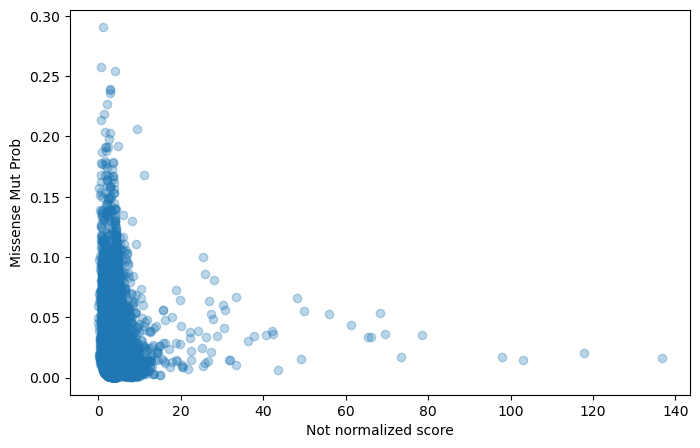

In [900]:
df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Score_0"], df_plot["Mis_mut_prob"], alpha=0.3)
plt.xlabel("Not normalized score")
plt.ylabel("Missense Mut Prob")
plt.show()

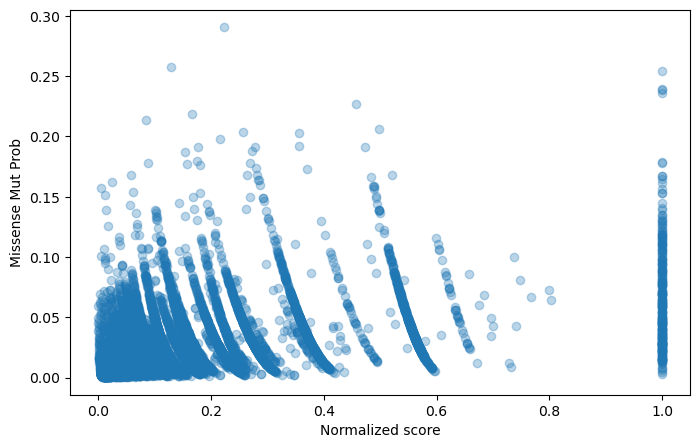

In [901]:
df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Score_1"], df_plot["Mis_mut_prob"], alpha=0.3)
plt.xlabel("Normalized score")
plt.ylabel("Missense Mut Prob")
plt.show()

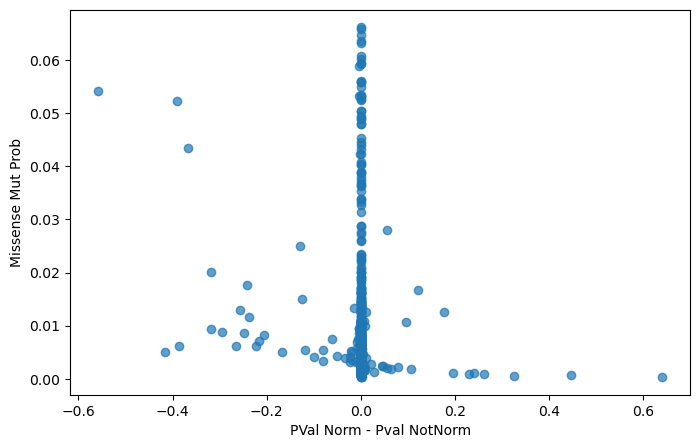

In [928]:
df_plot = df[df["Mut_in_gene"] > 40].copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Pval_diff"], df_plot["Mis_mut_prob"], alpha=0.7)
plt.xlabel("PVal Norm - Pval NotNorm")
plt.ylabel("Missense Mut Prob")
plt.show()

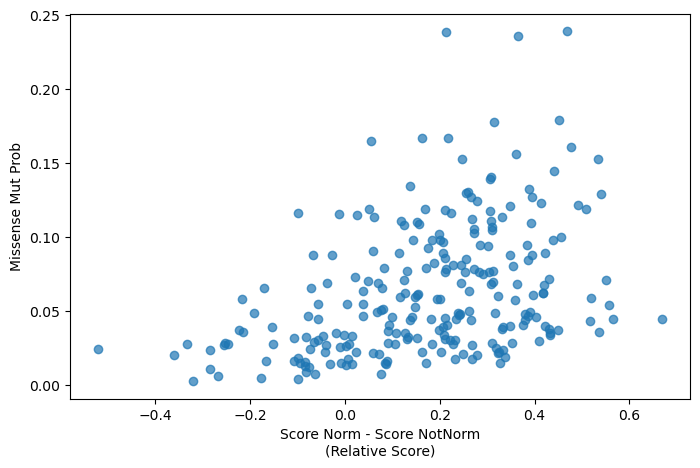

In [929]:
df_plot = df[df["Mut_in_gene"] == 2].copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Score_diff"], df_plot["Mis_mut_prob"], alpha=0.7)
plt.xlabel("Score Norm - Score NotNorm\n(Relative Score)")
plt.ylabel("Missense Mut Prob")
plt.show()

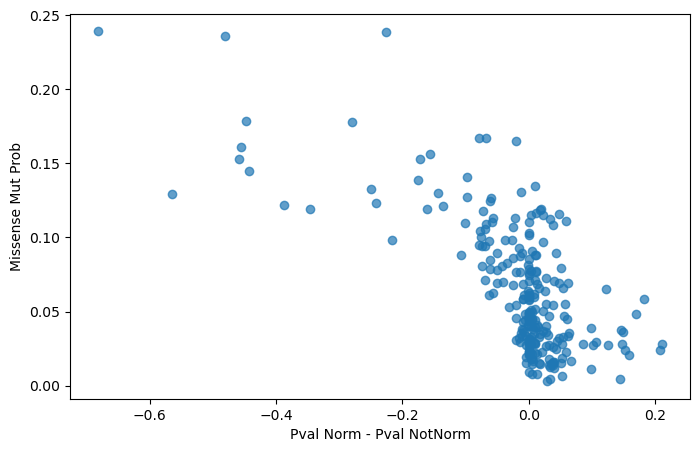

In [930]:
df_plot = df[df["Mut_in_gene"] == 2].copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Pval_diff"], df_plot["Mis_mut_prob"], alpha=0.7)
plt.xlabel("Pval Norm - Pval NotNorm")
plt.ylabel("Missense Mut Prob")
plt.show()

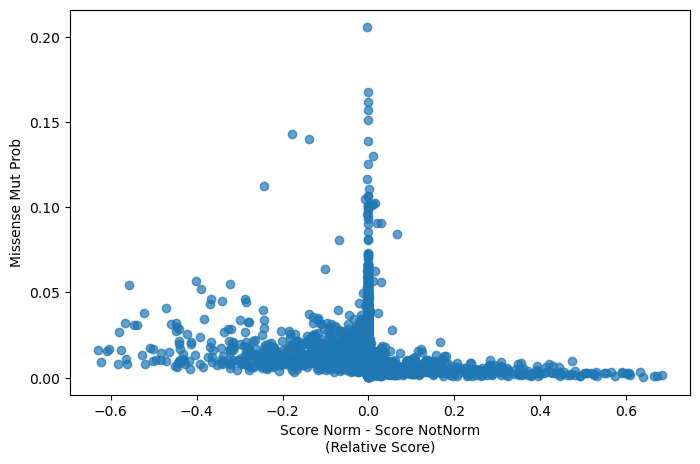

In [931]:
df_plot = df[df["Mut_in_gene"] > 10].copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Pval_diff"], df_plot["Mis_mut_prob"], alpha=0.7)
plt.xlabel("Score Norm - Score NotNorm\n(Relative Score)")
plt.ylabel("Missense Mut Prob")
plt.show()

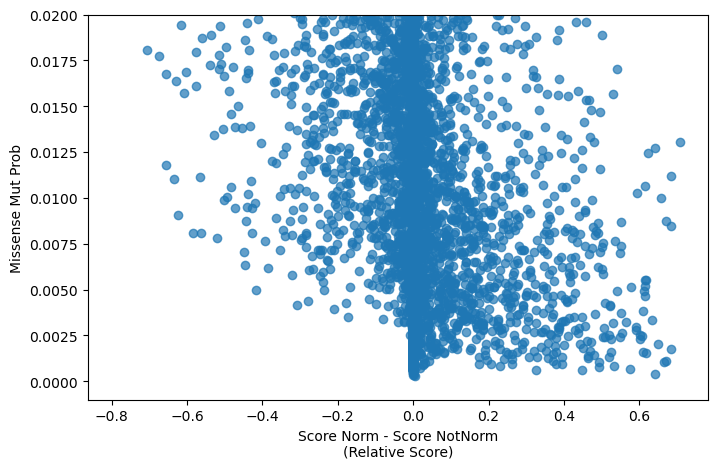

In [932]:
df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Pval_diff"], df_plot["Mis_mut_prob"], alpha=0.7)
plt.xlabel("Score Norm - Score NotNorm\n(Relative Score)")
plt.ylabel("Missense Mut Prob")
plt.ylim(-0.001, 0.02)
plt.show()

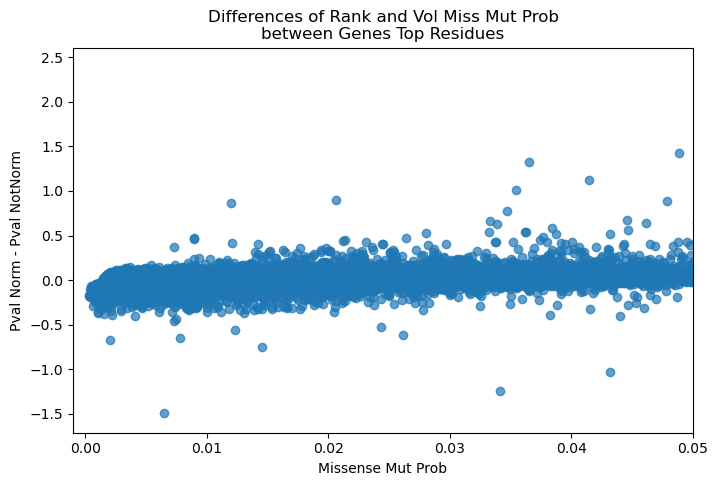

In [865]:
df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Mis_mut_prob"], df_plot["Score_diff"], alpha=0.7)
plt.ylabel("Pval Norm - Pval NotNorm")
plt.xlabel("Missense Mut Prob")
plt.xlim(-0.001, 0.05)
plt.title("Differences of Rank and Vol Miss Mut Prob\nbetween Genes Top Residues")
plt.show()

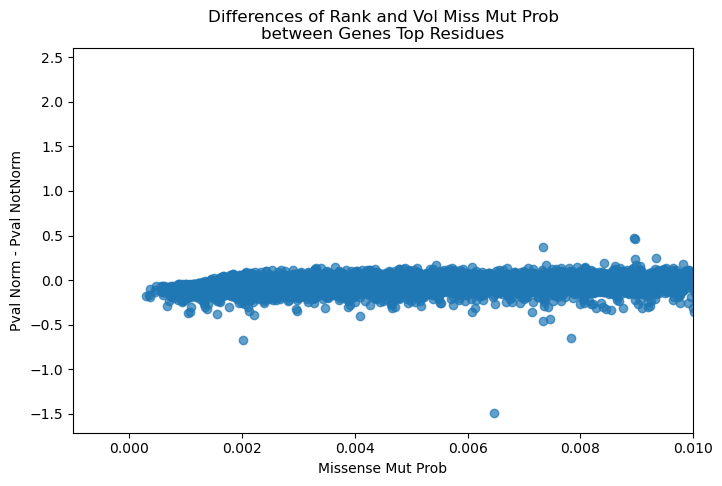

In [866]:
df_plot = df.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Mis_mut_prob"], df_plot["Score_diff"], alpha=0.7)
plt.ylabel("Pval Norm - Pval NotNorm")
plt.xlabel("Missense Mut Prob")
plt.xlim(-0.001, 0.01)

plt.title("Differences of Rank and Vol Miss Mut Prob\nbetween Genes Top Residues")
plt.show()

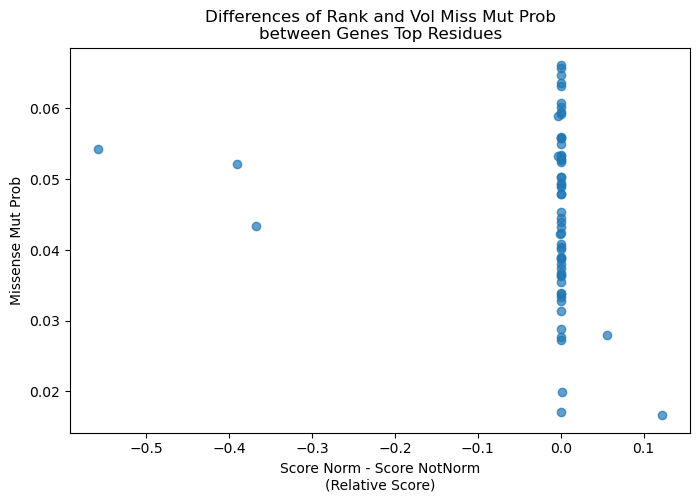

In [868]:
df_gene = df[df["Gene"] == "TP53"]
df_gene.corr()

df_plot = df_gene.copy()
plt.figure(figsize=(8, 5))
plt.scatter(df_plot["Pval_diff"], df_plot["Mis_mut_prob"], alpha=0.7)
plt.xlabel("Score Norm - Score NotNorm\n(Relative Score)")
plt.ylabel("Missense Mut Prob")
plt.title("Differences of Rank and Vol Miss Mut Prob\nbetween Genes Top Residues")
plt.show()

In [853]:
cols = ["Rank_1", "Rank_0", "pval_1", "pval_0", "Score_1", "Score_0", "Score_obs_sim_1", "Score_obs_sim_0", "Mis_mut_prob", "Mut_in_vol_1", "Mut_in_gene", "Rank_diff", "Pval_diff", "Score_diff"]
df_corr = df[cols].corr()
df_corr

Rank_1    Rank_0    pval_1    pval_0   Score_1   Score_0  \
Rank_1           1.000000  0.999350  0.325597  0.299226 -0.394459 -0.275872   
Rank_0           0.999350  1.000000  0.325181  0.299263 -0.394232 -0.276198   
pval_1           0.325597  0.325181  1.000000  0.922027 -0.754511 -0.584799   
pval_0           0.299226  0.299263  0.922027  1.000000 -0.721912 -0.604770   
Score_1         -0.394459 -0.394232 -0.754511 -0.721912  1.000000  0.362094   
Score_0         -0.275872 -0.276198 -0.584799 -0.604770  0.362094  1.000000   
Score_obs_sim_1 -0.189369 -0.189071 -0.631879 -0.614230  0.430861  0.934299   
Score_obs_sim_0 -0.204825 -0.204859 -0.594897 -0.613530  0.401775  0.960228   
Mis_mut_prob    -0.260680 -0.258065 -0.295040 -0.182460  0.493062 -0.001794   
Mut_in_vol_1    -0.100888 -0.099511 -0.446367 -0.422265  0.198267  0.813988   
Mut_in_gene      0.677153  0.677153  0.140188  0.119151 -0.377573  0.107655   
Rank_diff        0.018022 -0.018022  0.011530 -0.001013 -0.006316  0.009032   
Pval_diff        0.067774  0.066629  0.200510 -0.194387 -0.084901  0.048676   
Score_diff       0.022984  0.024839 -0.394983 -0.196204  0.289939  0.154670   

                 Score_obs_sim_1  Score_obs_sim_0  Mis_mut_prob  Mut_in_vol_1  \
Rank_1                 -0.189369        -0.204825     -0.260680     -0.100888   
Rank_0                 -0.189071        -0.204859     -0.258065     -0.099511   
pval_1                 -0.631879        -0.594897     -0.295040     -0.446367   
pval_0                 -0.614230        -0.613530     -0.182460     -0.422265   
Score_1                 0.430861         0.401775      0.493062      0.198267   
Score_0                 0.934299         0.960228     -0.001794      0.813988   
Score_obs_sim_1         1.000000         0.984989      0.131626      0.908235   
Score_obs_sim_0         0.984989         1.000000      0.063042      0.889956   
Mis_mut_prob            0.131626         0.063042      1.000000      0.168036   
Mut_in_vol_1            0.908235         0.889956      0.168036      1.000000   
Mut_in_gene             0.162605         0.161161     -0.299327      0.356244   
Rank_diff              -0.008250         0.000925     -0.072543     -0.038201   
Pval_diff              -0.046677         0.045260     -0.285826     -0.062416   
Score_diff              0.393316         0.228707      0.406633      0.381966   

                  Mut_in_gene     Rank_diff  Pval_diff  Score_diff  
Rank_1           6.771531e-01  1.802167e-02   0.067774    0.022984  
Rank_0           6.771531e-01 -1.802167e-02   0.066629    0.024839  
pval_1           1.401877e-01  1.153001e-02   0.200510   -0.394983  
pval_0           1.191507e-01 -1.013461e-03  -0.194387   -0.196204  
Score_1         -3.775734e-01 -6.316112e-03  -0.084901    0.289939  
Score_0          1.076549e-01  9.032499e-03   0.048676    0.154670  
Score_obs_sim_1  1.626045e-01 -8.250407e-03  -0.046677    0.393316  
Score_obs_sim_0  1.611609e-01  9.249267e-04   0.045260    0.228707  
Mis_mut_prob    -2.993269e-01 -7.254297e-02  -0.285826    0.406633  
Mut_in_vol_1     3.562437e-01 -3.820108e-02  -0.062416    0.381966  
Mut_in_gene      1.000000e+00 -1.143986e-18   0.053685    0.058644  
Rank_diff       -1.143986e-18  1.000000e+00   0.031780   -0.051456  
Pval_diff        5.368475e-02  3.178037e-02   1.000000   -0.504307  
Score_diff       5.864353e-02 -5.145555e-02  -0.504307    1.000000

In [854]:
df_gene = df[df["Gene"] == "TP53"]
df_corr = df_gene[cols].corr()
df_corr

Rank_1    Rank_0    pval_1    pval_0   Score_1   Score_0  \
Rank_1           1.000000  0.998444  0.826040  0.838051 -0.861459 -0.852485   
Rank_0           0.998444  1.000000  0.826041  0.838060 -0.860633 -0.853321   
pval_1           0.826040  0.826041  1.000000  0.976240 -0.516619 -0.506292   
pval_0           0.838051  0.838060  0.976240  1.000000 -0.535502 -0.525218   
Score_1         -0.861459 -0.860633 -0.516619 -0.535502  1.000000  0.995821   
Score_0         -0.852485 -0.853321 -0.506292 -0.525218  0.995821  1.000000   
Score_obs_sim_1 -0.924166 -0.924409 -0.622943 -0.642492  0.965470  0.953368   
Score_obs_sim_0 -0.920728 -0.920581 -0.611150 -0.631384  0.972507  0.966230   
Mis_mut_prob    -0.245361 -0.225027 -0.369606 -0.328189  0.090383  0.037645   
Mut_in_vol_1    -0.955563 -0.951837 -0.693098 -0.702941  0.955051  0.938949   
Mut_in_gene           NaN       NaN       NaN       NaN       NaN       NaN   
Rank_diff        0.027893 -0.027893 -0.000008 -0.000158 -0.014814  0.014989   
Pval_diff       -0.120087 -0.120126  0.031285 -0.186042  0.127559  0.126948   
Score_diff      -0.634882 -0.638022 -0.500196 -0.507856  0.582215  0.529840   

                 Score_obs_sim_1  Score_obs_sim_0  Mis_mut_prob  Mut_in_vol_1  \
Rank_1                 -0.924166        -0.920728     -0.245361     -0.955563   
Rank_0                 -0.924409        -0.920581     -0.225027     -0.951837   
pval_1                 -0.622943        -0.611150     -0.369606     -0.693098   
pval_0                 -0.642492        -0.631384     -0.328189     -0.702941   
Score_1                 0.965470         0.972507      0.090383      0.955051   
Score_0                 0.953368         0.966230      0.037645      0.938949   
Score_obs_sim_1         1.000000         0.995517      0.176729      0.979820   
Score_obs_sim_0         0.995517         1.000000      0.124042      0.972608   
Mis_mut_prob            0.176729         0.124042      1.000000      0.291637   
Mut_in_vol_1            0.979820         0.972608      0.291637      1.000000   
Mut_in_gene                  NaN              NaN           NaN           NaN   
Rank_diff               0.004356        -0.002650     -0.364500     -0.066796   
Pval_diff               0.138957         0.141189     -0.162097      0.099675   
Score_diff              0.692798         0.621488      0.518122      0.700313   

                 Mut_in_gene  Rank_diff  Pval_diff  Score_diff  
Rank_1                   NaN   0.027893  -0.120087   -0.634882  
Rank_0                   NaN  -0.027893  -0.120126   -0.638022  
pval_1                   NaN  -0.000008   0.031285   -0.500196  
pval_0                   NaN  -0.000158  -0.186042   -0.507856  
Score_1                  NaN  -0.014814   0.127559    0.582215  
Score_0                  NaN   0.014989   0.126948    0.529840  
Score_obs_sim_1          NaN   0.004356   0.138957    0.692798  
Score_obs_sim_0          NaN  -0.002650   0.141189    0.621488  
Mis_mut_prob             NaN  -0.364500  -0.162097    0.518122  
Mut_in_vol_1             NaN  -0.066796   0.099675    0.700313  
Mut_in_gene              NaN        NaN        NaN         NaN  
Rank_diff                NaN   1.000000   0.000693    0.056289  
Pval_diff                NaN   0.000693   1.000000    0.074502  
Score_diff               NaN   0.056289   0.074502    1.000000

In [855]:
df_gene.sort_values("Rank_1").reset_index(drop=True)[cols]

Rank_1  Rank_0  pval_1  pval_0       Score_1    Score_0  Score_obs_sim_1  \
0        0       0  0.0000  0.0000  1.517018e-01  78.559516        11.947984   
1        1       2  0.0000  0.0000  1.506648e-01  68.422578        13.338605   
2        2       1  0.0000  0.0000  1.355608e-01  69.571931        13.009087   
3        3       5  0.0000  0.0000  1.267943e-01  61.385118        12.996948   
4        4       3  0.0000  0.0000  1.251795e-01  66.011381        13.554702   
5        5       4  0.0000  0.0000  1.244898e-01  65.328388        14.154236   
6        6       6  0.0000  0.0000  1.226147e-01  56.043275        14.570084   
7        7       8  0.0000  0.0000  1.141351e-01  48.050209        14.133929   
8        8       7  0.0000  0.0000  1.109642e-01  49.910636        14.277052   
9        9      10  0.0000  0.0000  8.367545e-02  42.127411        11.168047   
10      10       9  0.0000  0.0000  8.217868e-02  42.250582        11.343094   
11      11      11  0.0000  0.0000  6.872738e-02  30.734842         9.790293   
12      12      14  0.0000  0.0000  6.295495e-02  26.895037         9.237610   
13      13      13  0.0000  0.0000  5.995003e-02  27.310382         9.048476   
14      14      12  0.0000  0.0000  5.945499e-02  27.817393         9.219389   
15      15      15  0.0000  0.0000  4.373208e-02  22.165229         6.961040   
16      16      17  0.0000  0.0000  3.849203e-02  17.833812         6.278202   
17      17      16  0.0000  0.0000  3.559557e-02  19.792107         5.947712   
18      18      19  0.0000  0.0000  3.519611e-02  15.741082         6.013023   
19      19      20  0.0000  0.0000  3.512807e-02  15.699107         6.132329   
20      20      18  0.0000  0.0000  3.404940e-02  16.040996         6.068011   
21      21      21  0.0000  0.0000  2.693520e-02  13.356217         4.897093   
22      22      22  0.0000  0.0000  2.481826e-02  10.813692         4.600978   
23      23      23  0.0000  0.0000  2.473789e-02  10.438426         4.675761   
24      24      24  0.0000  0.0000  1.739445e-02   8.061699         3.351340   
25      25      26  0.0000  0.0000  1.620006e-02   7.363909         3.181123   
26      26      28  0.0000  0.0000  1.607411e-02   6.821166         3.213885   
27      27      27  0.0000  0.0000  1.604942e-02   7.033998         3.264307   
28      28      25  0.0000  0.0000  1.558131e-02   7.837829         3.223525   
29      29      30  0.0000  0.0000  1.058149e-02   4.828273         2.225302   
30      30      29  0.0000  0.0000  1.000497e-02   4.870708         2.138782   
31      31      31  0.0000  0.0000  9.919968e-03   4.633160         2.154598   
32      32      32  0.0000  0.0002  9.265048e-03   3.967898         2.044121   
33      33      33  0.0007  0.0003  7.571224e-03   3.773522         1.695632   
34      34      36  0.0006  0.0039  7.294394e-03   3.202244         1.657141   
35      35      35  0.0005  0.0035  7.199091e-03   3.272555         1.660166   
36      36      34  0.0005  0.0018  6.992837e-03   3.428942         1.636031   
37      37      37  0.1293  0.0071  4.840329e-03   3.071861         1.148057   
38      38      38  0.1272  0.0713  4.780232e-03   2.650532         1.149353   
39      39      39  0.1111  0.5020  4.774721e-03   2.185657         1.163476   
40      40      40  0.2190  0.7765  4.394853e-03   1.985407         1.084882   
41      41      41  0.3693  0.7373  4.078856e-03   1.984186         1.020397   
42      42      42  0.9999  0.9985  2.676823e-03   1.625810         0.678002   
43      43      43  1.0000  1.0000  2.473825e-03   1.074161         0.634506   
44      44      44  1.0000  1.0000  2.004464e-03   1.021047         0.520599   
45      45      45  1.0000  1.0000  1.661944e-03   0.826348         0.436873   
46      46      46  1.0000  1.0000  1.399668e-03   0.769355         0.372381   
47      47      47  1.0000  1.0000  1.326765e-03   0.679300         0.357287   
48      48      49  1.0000  1.0000  1.284658e-03   0.619701         0.350186   
49  

## All residues result

In [982]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Score", "Score_obs_sim", "pval", "Rank"]
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            #df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df).reset_index(drop=True)

    return df

In [1000]:
SUBDIR = "review"
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

RUN = "run_control_2025-03-21_11-24-24"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"
df_norm = get_all_o3d_res_result(cohort_df, o3d_output_dir)


RUN = "run_notnorm_2025-03-26_10-58-45"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"
df_notnorm = get_all_o3d_res_result(cohort_df, o3d_output_dir)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_control_2025-03-21_11-24-24/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv
Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


In [1001]:
# cols = ["Gene", "index", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_gene", "Mut_in_top_vol", "Pos_top_vol", "Seq_Length"]
df_norm = df_norm.rename(columns={col:f"{col}_1" for col in df_norm.columns if col not in ["Cohort", "Gene", "Pos"]})
df_notnorm = df_notnorm.rename(columns={col:f"{col}_0" for col in df_notnorm.columns if col not in ["Cohort", "Gene", "Pos"]})
df = df_norm.merge(df_notnorm, on=["Cohort", "Gene", "Pos"], how="outer")
df

Cohort     Gene  Pos Mut_in_gene_1   Score_1  \
0       HARTWIG_WGS_BLCA_2023  AADACL4  125             2       1.0   
1       HARTWIG_WGS_BLCA_2023  AADACL4   73             2       1.0   
2       HARTWIG_WGS_BLCA_2023     AASS  280             5  0.278982   
3       HARTWIG_WGS_BLCA_2023     AASS  283             5  0.285179   
4       HARTWIG_WGS_BLCA_2023     AASS  663             5  0.124849   
...                       ...      ...  ...           ...       ...   
616627          TCGA_WXS_PGNG      RET  515             7  0.080308   
616628          TCGA_WXS_PGNG     SIX4   14             2       1.0   
616629          TCGA_WXS_PGNG    SPON1  675             2       1.0   
616630          TCGA_WXS_PGNG    SPON1  674             2       1.0   
616631          TCGA_WXS_PGNG    SUSD4  184             2       1.0   

       Score_obs_sim_1  pval_1 Rank_1 Mut_in_gene_0   Score_0 Score_obs_sim_0  \
0             1.430101  0.1433      1             2   6.28387        1.394335   
1             1.337113  0.1851      0             2  6.518757        1.327149   
2             0.976166  0.4438      1             5  5.196341        0.909303   
3             0.933392  0.5203      0             5  5.622089        0.905672   
4             0.459892     1.0      2             5   2.62412        0.486967   
...                ...     ...    ...           ...       ...             ...   
616627        0.446074     1.0      3             7  2.449131        0.458074   
616628        1.852138  0.0268      0             2  9.111088        1.714995   
616629        1.791595  0.0387      1             2  8.019134        1.635836   
616630        1.745673  0.0458      0             2  8.148442        1.586689   
616631        1.668006  0.0635      0             2   8.32794         1.68275   

        pval_0 Rank_0  
0        0.135      1  
1       0.1758      0  
2        0.483      1  
3       0.5329      0  
4          1.0      2  
...        ...    ...  
616627     1.0      3  
616628   0.009      0  
616629  0.0302      1  
616630  0.0375      0  
616631  0.0269      0  

[616632 rows x 13 columns]

In [1019]:
df.drop(columns=["Cohort", "Gene", "Pos"]).astype(float).corr()[["Score_1", "Score_0", "Rank_1", "Rank_0", "pval_1", "pval_0"]]

Score_1   Score_0    Rank_1    Rank_0    pval_1    pval_0
Mut_in_gene_1   -0.282408  0.033815  0.780348  0.780348  0.149711  0.136201
Score_1          1.000000  0.250585 -0.271987 -0.271871 -0.778607 -0.762859
Score_obs_sim_1  0.299423  0.957147 -0.105267 -0.105071 -0.397722 -0.391994
pval_1          -0.778607 -0.338385  0.227538  0.227386  1.000000  0.950950
Rank_1          -0.271987 -0.129200  1.000000  0.997978  0.227538  0.214974
Mut_in_gene_0   -0.282408  0.033815  0.780348  0.780348  0.149711  0.136201
Score_0          0.250585  1.000000 -0.129200 -0.129528 -0.338385 -0.344631
Score_obs_sim_0  0.268969  0.976504 -0.103229 -0.103357 -0.355941 -0.362545
pval_0          -0.762859 -0.344631  0.214974  0.215011  0.950950  1.000000
Rank_0          -0.271871 -0.129528  0.997978  1.000000  0.227386  0.215011

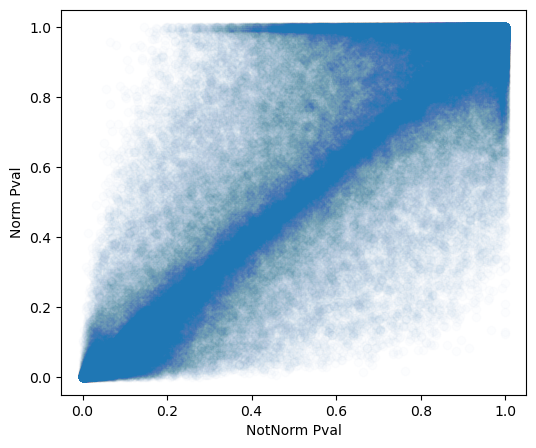

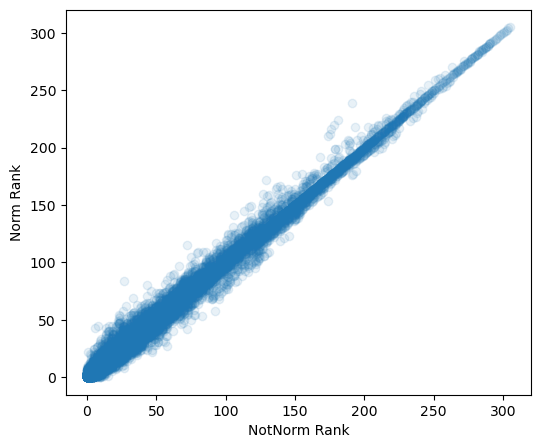

In [988]:
df_plot = df.copy()
plt.figure(figsize=(6, 5))
plt.scatter(df_plot["pval_1"], df_plot["pval_0"], alpha=0.01)
plt.xlabel("NotNorm Pval")
plt.ylabel("Norm Pval")
plt.show()

df_plot = df.copy()
plt.figure(figsize=(6, 5))
plt.scatter(df_plot["Rank_1"], df_plot["Rank_0"], alpha=0.1)
plt.xlabel("NotNorm Rank")
plt.ylabel("Norm Rank")
plt.show()

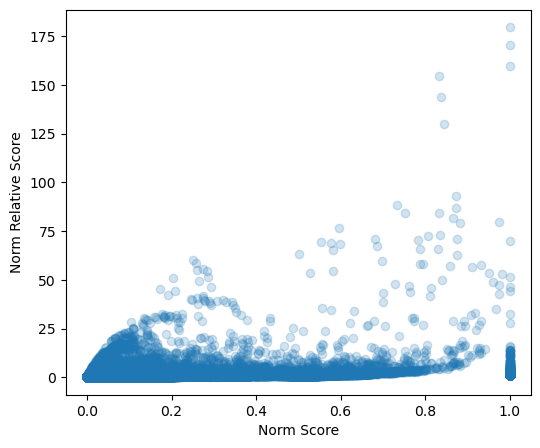

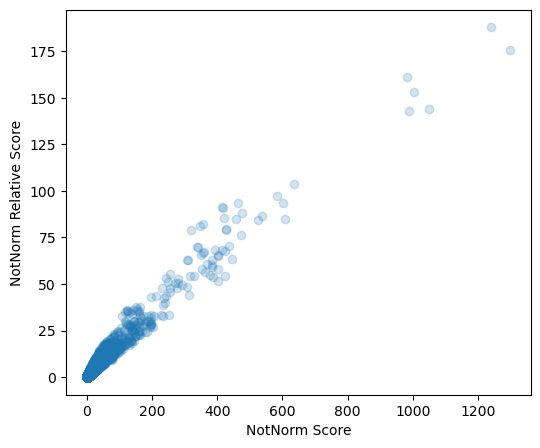

In [994]:
df_plot = df.copy()
plt.figure(figsize=(6, 5))
plt.scatter(df_plot["Score_1"], df_plot["Score_obs_sim_1"], alpha=0.2)
plt.xlabel("Norm Score")
plt.ylabel("Norm Relative Score")
plt.show()


df_plot = df.copy()
plt.figure(figsize=(6, 5))
plt.scatter(df_plot["Score_0"], df_plot["Score_obs_sim_0"], alpha=0.2)
plt.xlabel("NotNorm Score")
plt.ylabel("NotNorm Relative Score")
plt.show()

In [1022]:
df.sort_values("Score_obs_sim_1", ascending=False)[:60]

Cohort    Gene   Pos Mut_in_gene_1   Score_1  \
568579              TCGA_WXS_WDTC    BRAF   600           287       1.0   
436263            TCGA_WXS_LGGNOS    IDH1   132           395       1.0   
568580              TCGA_WXS_WDTC    BRAF   601           287       1.0   
300683               TCGA_WXS_MEL    BRAF   600           269  0.833223   
300684               TCGA_WXS_MEL    BRAF   601           269   0.83739   
300685               TCGA_WXS_MEL    BRAF   597           269  0.845096   
77380       HARTWIG_WGS_SKCM_2023    BRAF   600           152  0.871862   
27459   HARTWIG_WGS_COADREAD_2023    KRAS    14           238  0.733995   
77381       HARTWIG_WGS_SKCM_2023    BRAF   601           152  0.873916   
27460   HARTWIG_WGS_COADREAD_2023    KRAS    60           238  0.831414   
27461   HARTWIG_WGS_COADREAD_2023    KRAS    13           238  0.752288   
221181   OTHER_WGS_MM_NATLEUK2018    NRAS    13           216  0.865472   
437044     PCAWG_WGS_PANC_ADENOCA    KRAS    61           192  0.974631   
77382       HARTWIG_WGS_SKCM_2023    BRAF   597           152  0.883215   
27462   HARTWIG_WGS_COADREAD_2023    KRAS    61           238  0.596954   
27463   HARTWIG_WGS_COADREAD_2023    KRAS    12           238  0.834197   
437045     PCAWG_WGS_PANC_ADENOCA    KRAS    13           192  0.806977   
221182   OTHER_WGS_MM_NATLEUK2018    NRAS    12           216  0.874123   
221183   OTHER_WGS_MM_NATLEUK2018    NRAS    61           216  0.680933   
131518      HARTWIG_WGS_BRCA_2023    ESR1   537           133  0.782808   
437046     PCAWG_WGS_PANC_ADENOCA    KRAS    12           192       1.0   
221184   OTHER_WGS_MM_NATLEUK2018    NRAS    64           216  0.553366   
221185   OTHER_WGS_MM_NATLEUK2018    NRAS    62           216  0.577123   
219991   OTHER_WGS_MM_NATLEUK2018    KRAS    61           265  0.597502   
219992   OTHER_WGS_MM_NATLEUK2018    KRAS    12           265  0.685708   
497103              TCGA_WXS_LUAD    KRAS    61           165  0.829136   
131519      HARTWIG_WGS_BRCA_2023    ESR1   538           133  0.786609   
221186   OTHER_WGS_MM_NATLEUK2018    NRAS    59           216  0.582003   
219993   OTHER_WGS_MM_NATLEUK2018    KRAS    59           265  0.500428   
497104              TCGA_WXS_LUAD    KRAS    13           165  0.875907   
542492              TCGA_WXS_BRCA  PIK3CA  1043           360  0.250706   
574265          TCGA_WXS_COADREAD    KRAS    13           202  0.698662   
542493              TCGA_WXS_BRCA  PIK3CA  1044           360  0.257055   
131520      HARTWIG_WGS_BRCA_2023    ESR1   536           133  0.787299   
574266          TCGA_WXS_COADREAD    KRAS    12           202  0.793779   
497105              TCGA_WXS_LUAD    KRAS    12           165  0.932256   
372061               TCGA_WXS_MEL    NRAS    62           127  0.858822   
372062               TCGA_WXS_MEL    NRAS    61           127  0.911724   
135436      HARTWIG_WGS_BRCA_2023  PIK3CA  1043           302  0.273247   
542494              TCGA_WXS_BRCA  PIK3CA  1047           360  0.259884   
574267          TCGA_WXS_COADREAD    KRAS    61           202  0.581908   
135437      HARTWIG_WGS_BRCA_2023  PIK3CA  1044           302  0.282651   
372063               TCGA_WXS_MEL    NRAS    13           127  0.950052   
574268          TCGA_WXS_COADREAD    KRAS    59           202  0.526474   
139879        CPTAC_WXS_PAAD_2021    KRAS    61           126  0.980736   
147532  HARTWIG_WGS_PANCREAS_2023    KRAS    12           120       1.0   
135438      HARTWIG_WGS_BRCA_2023  PIK3CA  1047           302   0.28718   
542495              TCGA_WXS_BRCA  PIK3CA   545           360  0.202325   
139880        CPTAC_WXS_PAAD_2021    KRAS    13           126  0.838928   
542496              TCGA_WXS_BRCA  PIK3CA  1049           360  0.265069   
435710              TCGA_WXS_PAAD    KRAS    61           119  0.961108   
5562     CBIOP_WXS_CM_VALLEN_2018    BRAF   602            87  0.729218   
372064               TCGA_WXS_MEL    NRAS    12     

## Notes
* We only compute p-values for genes with at least 2 mutations in the volume of any residue
* The pvalues of cohorts with 1000+ processed genes (N) seem to be well calibrated 
* There isn't an apparent correlation between sample size (number of processed genes and mutations) and deviation from neutrality